In [2]:
import os
from datetime import datetime
import gc
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import warnings


import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import tensorflow as tf

matplotlib.rcParams['figure.dpi'] = 100
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
warnings.simplefilter('ignore')

**Usefull functions**

In [3]:
## Memory optimization

# Original code from https://www.kaggle.com/code/rohanrao/ashrae-half-and-half/notebook
def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#        else:
#            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# Perform a one hot encoding
def one_hot(train, feature, test=None):
    train2 = train.copy()
    train2[f'{feature}s'] = train2[feature]
    train2 = pd.get_dummies(train2, columns=[feature], prefix=[f'{feature}_'])
    if test is None:
        return(train2)
    else:
        test2 = test.copy()
        test2[f'{feature}s'] = test2[feature]
        test2 = pd.get_dummies(test2, columns=[feature], prefix=[f'{feature}_'])
        return(train2, test2)

# Perform a label encoding
def label_encode(train, feature, test=None):
    le = LabelEncoder()
    train2 = train.copy()
    train2[feature] = le.fit_transform(train2[feature])
    if test is None:
        return(train2)
    else:
        test2 = test.copy()
        test2[feature] = le.transform(test2[feature])
        return(train2, test2)

# Extract time features
def extract_time_features(train, time_feature, test=None):
    train['month'] = train[time_feature].dt.month
    train['weekday'] = train[time_feature].dt.weekday
    train['hour'] = train[time_feature].dt.hour
    train['day'] = train[time_feature].dt.day
    train.sort_values(time_feature, inplace=True)
    train.reset_index(drop=True, inplace=True)
    
    if test is None:
        return(train)
    
    else:
        test['month'] = test[time_feature].dt.month
        test['weekday'] = test[time_feature].dt.weekday
        test['hour'] = test[time_feature].dt.hour
        test['day'] = test[time_feature].dt.day
        test.sort_values(time_feature, inplace=True)
        test.reset_index(drop=True, inplace=True)
        return(train, test)
        
# Add holidays based on a list of public holidays dates
def add_holidays(train, holidays, test=None):
    train["is_holiday"] = (train['timestamp'].dt.date.astype("str").isin(holidays)).astype(int)
    if test is None:
        return(train)
    else:
        test["is_holiday"] = (test['timestamp'].dt.date.astype("str").isin(holidays)).astype(int)
        return(train, test)

# Scale data using minmax scaler
def scale_numerical_feature(train, num_features, test=None):
    scaler = MinMaxScaler()
    train2 = train.copy()
    train2[num_features] = scaler.fit_transform(train2[num_features])
    if test is None:
        return(train2)
    else:
        test2 = test.copy()
        test2[num_features] = scaler.transform(test2[num_features])
    return(train2, test2)

# Data Loading & Exploration

In [5]:
# Load all the data from csv
train_raw = pd.read_csv("/kaggle/input/ashrae-energy-prediction/train.csv", sep = ',')
test_raw = pd.read_csv("/kaggle/input/ashrae-energy-prediction/test.csv", sep = ',')
b_meta = pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv",sep = ',')
w_train = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_train.csv",sep = ',')
w_test = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_test.csv",sep = ',')
sample = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv",sep = ',')

In [6]:
# Reduce memory usage to preserve RAM
train_raw = reduce_mem_usage(train_raw, use_float16=True)
test_raw = reduce_mem_usage(test_raw, use_float16=True)
b_meta = reduce_mem_usage(b_meta, use_float16=True)
w_train = reduce_mem_usage(w_train, use_float16=True)
w_test = reduce_mem_usage(w_test, use_float16=True)
sample = reduce_mem_usage(sample, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%
Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


Explore the number of rows and columns per dataframe

In [7]:
tables = [train_raw, test_raw, b_meta, w_train, w_test, sample]
table_names = ['train_raw', 'test_raw', 'b_meta', 'w_train', 'w_test', 'sample']
for name, i in zip(table_names,tables):
    print(f"table en cours d'étude: {name}")
    print(i.columns)
    print(i.shape,'\n')

table en cours d'étude: train_raw
Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')
(20216100, 4) 

table en cours d'étude: test_raw
Index(['row_id', 'building_id', 'meter', 'timestamp'], dtype='object')
(41697600, 4) 

table en cours d'étude: b_meta
Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')
(1449, 6) 

table en cours d'étude: w_train
Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
(139773, 9) 

table en cours d'étude: w_test
Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
(277243, 9) 

table en cours d'étude: sample
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2) 



## General Analysis

We will explore at high level the different dataframes by:
- giving the **meaning of each column**
- see if there are any **NaN values**
- see if there are any **duplicate values**

### Train_raw

- `building_id` - Foreign key for the building metadata.

- `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

- `timestamp` - When the measurement was taken

- `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.


__NaN values__

In [8]:
train_raw.isna().any()

building_id      False
meter            False
timestamp        False
meter_reading    False
dtype: bool

__Duplicate__

In [9]:
train_raw.duplicated(subset=['building_id','meter','timestamp'], keep=False).any()

False

### Test_raw

- `row_id` - Row id for your submission file
- `building_id` - Building id code
- `meter` - The meter id code
- `timestamp` - Timestamps for the test data period


__NaN values__

In [10]:
test_raw.isna().any()

row_id         False
building_id    False
meter          False
timestamp      False
dtype: bool

__Duplicate__

In [11]:
test_raw.duplicated(subset=['building_id','meter','timestamp'], keep=False).any()

False

### sample

- `row_id` - Row id for your submission file

- `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.


__NaN values__

In [12]:
sample.isna().any()

row_id           False
meter_reading    False
dtype: bool

__Duplicate__

In [13]:
sample.duplicated(subset=['row_id'], keep=False).any()

False

### b_meta

- `site_id` - Foreign key for the weather files. 
- `building_id` - Foreign key for training.csv
- `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- `square_feet` - Gross floor area of the building
- `year_built` - Year building was opened
- `floor_count` - Number of floors of the building


__NaN values__

In [14]:
b_meta.isna().any()

site_id        False
building_id    False
primary_use    False
square_feet    False
year_built      True
floor_count     True
dtype: bool

__Duplicate__

In [15]:
b_meta.duplicated(subset=['building_id'], keep=False).any()

False

### w_train

- `site_id`
- `air_temperature` - Degrees Celsius
- `cloud_coverage` - Portion of the sky covered in clouds, in oktas
- `dew_temperature` - Degrees Celsius
- `precip_depth_1_hr` - Millimeters
- `sea_level_pressure` - Millibar/hectopascals
- `wind_direction` - Compass direction (0-360)
- `wind_speed` - Meters per second


__NaN values__

In [16]:
w_train.isna().any(axis=0)

site_id               False
timestamp             False
air_temperature        True
cloud_coverage         True
dew_temperature        True
precip_depth_1_hr      True
sea_level_pressure     True
wind_direction         True
wind_speed             True
dtype: bool

__Duplicate__

In [17]:
w_train.duplicated(subset=['site_id','timestamp'], keep=False).any()

False

### w_test

- `site_id`
- `air_temperature` - Degrees Celsius
- `cloud_coverage` - Portion of the sky covered in clouds, in oktas
- `dew_temperature` - Degrees Celsius
- `precip_depth_1_hr` - Millimeters
- `sea_level_pressure` - Millibar/hectopascals
- `wind_direction` - Compass direction (0-360)
- `wind_speed` - Meters per second

__NaN values__

In [18]:
w_test.isna().any(axis=0)

site_id               False
timestamp             False
air_temperature        True
cloud_coverage         True
dew_temperature        True
precip_depth_1_hr      True
sea_level_pressure     True
wind_direction         True
wind_speed             True
dtype: bool

__Duplicate__

In [19]:
w_test.duplicated(subset=['site_id','timestamp'], keep=False).any()

False

**CONCLUSION** 

With this high-level analysis, we have seen that 
- there are **some missing values for the weather data and building metadata.**
- we **do not have any duplicated values** so joining table will be safe.

## Joining

In order to analyse, in a more precise way, we will first **join all the data** in order to get the global picture of our dataset

In [20]:
train_full_raw = train_raw.merge(b_meta, how='left', on='building_id')
train_full_raw = train_full_raw.merge(w_train, how='left', on=['site_id','timestamp'])

In [21]:
test_full_raw = test_raw.merge(sample, how='inner', on='row_id')
test_full_raw = test_full_raw.merge(b_meta, how='left', on='building_id')
test_full_raw = test_full_raw.merge(w_test, how='left', on=['site_id','timestamp'])

In [22]:
del b_meta, w_train, w_test, sample, train_raw, test_raw
gc.collect()

142

In [23]:
test_full_raw.drop('row_id',axis=1,inplace=True)

We convert `timetamp` data into a a **datetime** one in order to perform proper analysis 

In [24]:
train_full_raw['timestamp'] = pd.to_datetime(train_full_raw['timestamp'])
test_full_raw['timestamp'] = pd.to_datetime(test_full_raw['timestamp'])

## Analysis train_full_raw & test_full_raw

### Global observations

In [25]:
train_full_raw.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [26]:
train_full_raw.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.5             0.0   
1             20.0                NaN              1019.5             0.0   
2             20.0                NaN              1019.5             0.0   
3             20.0                NaN              1019.5             0.0   
4             20.0                NaN              1019.5             0.0   

   wind_speed  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

### Missing Values

We will count for each column the **percentage of missing values** in both **train and test sets**

In [27]:
# Count missing values for train set
total_train = train_full_raw.isnull().sum().sort_values(ascending = False)
percent_train = (train_full_raw.isnull().sum()/train_full_raw.isnull().count()*100).sort_values(ascending = False)
missing_val_train = pd.concat([total_train, percent_train], axis=1, keys=['Total', 'Percent'])

In [28]:
# Count missing values for test set
total_test = test_full_raw.isnull().sum().sort_values(ascending = False)
percent_test = (test_full_raw.isnull().sum()/test_full_raw.isnull().count()*100).sort_values(ascending = False)
missing_val_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])

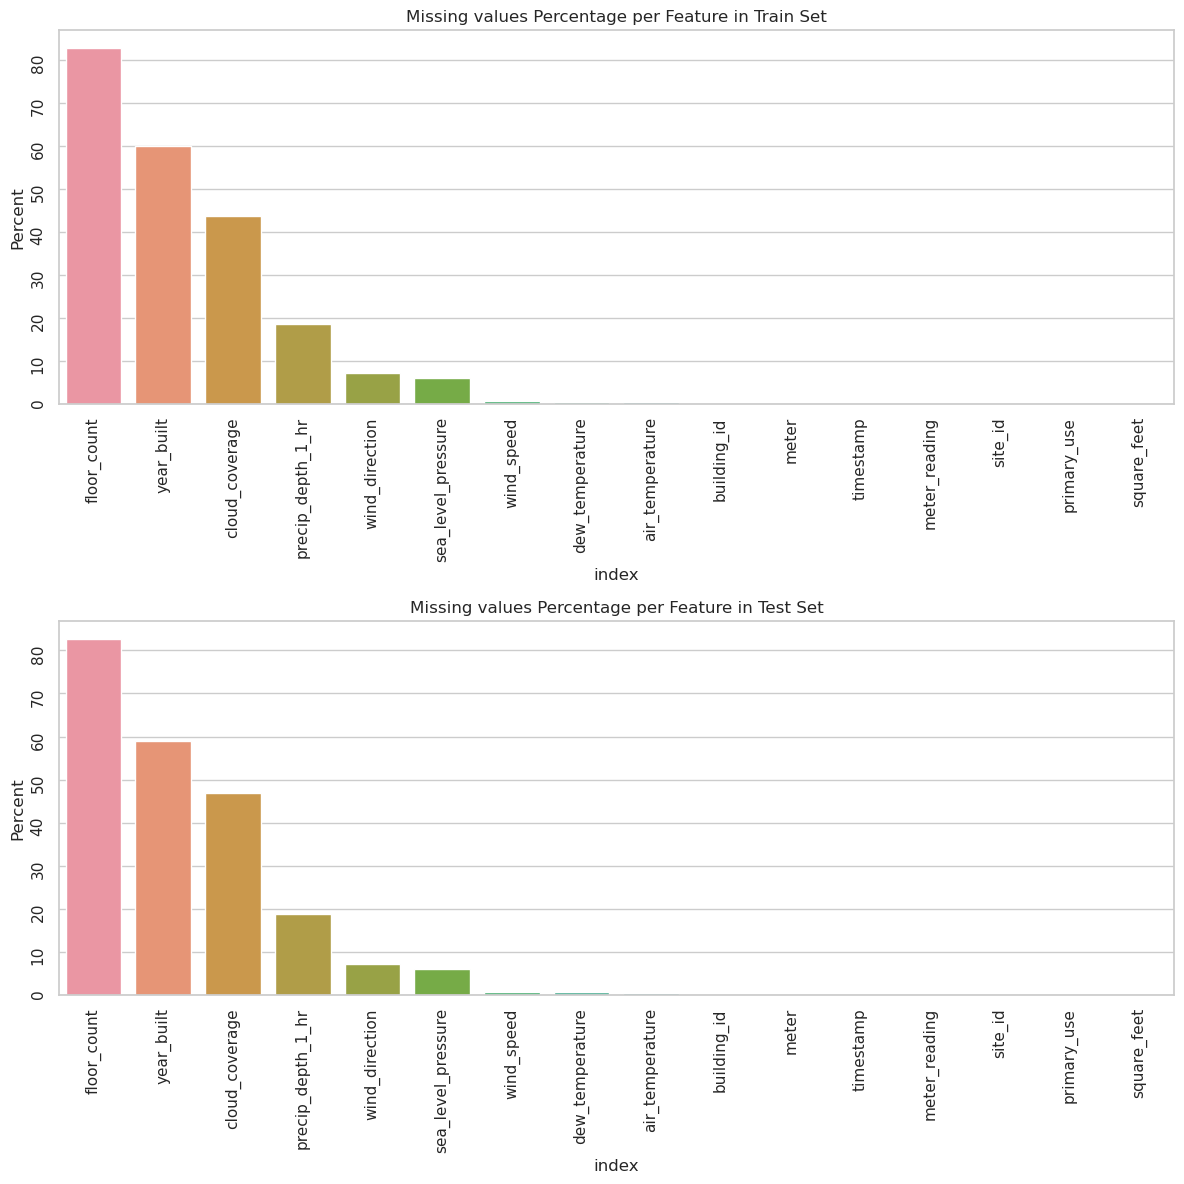

In [29]:
# Plot missing values
fig, axes = plt.subplots(2,figsize=(12,12))
sns.barplot(data=missing_val_train.reset_index(), y='Percent', x='index', ax=axes[0]).set(title='Missing values Percentage per Feature in Train Set');
axes[0].tick_params(labelrotation=90)
sns.barplot(data=missing_val_test.reset_index(), y='Percent', x='index', ax=axes[1]).set(title='Missing values Percentage per Feature in Test Set');
axes[1].tick_params(labelrotation=90)
plt.tight_layout()

**CONCLUSION**

We can see that we have the **same proportion of missing values for the train and test sets**.

`floor_count`, `year_built` and `cloud_coverage` are columns having the most NaN values with **more than 40% of NaN values**. 

This will be complicated to impute properly those missing data.

### Outliers

In [30]:
train_full_raw.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  2.021610e+07  2.021610e+07   2.021610e+07  2.021610e+07  2.021610e+07   
mean   7.992780e+02  6.624412e-01   2.117122e+03  7.992232e+00  1.077830e+05   
std    4.269133e+02  9.309921e-01   1.532356e+05  5.099060e+00  1.171424e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.930000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.950000e+02  0.000000e+00   7.877500e+01  9.000000e+00  7.270900e+04   
75%    1.179000e+03  1.000000e+00   2.679840e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count   8088455.0    3506933.0     2.011944e+07      11390735.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.890625e+01             0.0   
25%        1951.0          1.0     8.601562e+00             0.0   
50%        1969.0          3.0     1.670312e+01             0.0   
75%        1993.0          6.0     2.409375e+01             4.0   
max        2017.0         26.0     4.718750e+01             9.0   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     2.011596e+07         16467077.0          18984431.0      18767052.0   
mean               NaN                NaN                 NaN             NaN   
std       0.000000e+00                NaN                 NaN             NaN   
min      -3.500000e+01               -1.0               968.0             0.0   
25%       0.000000e+00                0.0              1011.5            70.0   
50%       8.898438e+00                0.0              1016.0           180.0   
75%       1.609375e+01                0.0              1020.5           280.0   
max       2.609375e+01              343.0              1046.0           360.0   

         wind_speed  
count  2.007242e+07  
mean            NaN  
std    0.000000e+00  
min    0.000000e+00  
25%    2.099609e+00  
50%    3.099609e+00  
75%    4.601562e+00  
max    1.900000e+01

In [31]:
test_full_raw.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  4.169760e+07  4.169760e+07     41697600.0  4.169760e+07  4.169760e+07   
mean   8.075824e+02  6.642857e-01            0.0  8.086134e+00  1.069469e+05   
std    4.297680e+02  9.278067e-01            0.0  5.134712e+00  1.160888e+05   
min    0.000000e+00  0.000000e+00            0.0  0.000000e+00  2.830000e+02   
25%    4.047500e+02  0.000000e+00            0.0  3.000000e+00  3.224350e+04   
50%    9.000000e+02  0.000000e+00            0.0  9.000000e+00  7.226250e+04   
75%    1.194250e+03  1.000000e+00            0.0  1.300000e+01  1.383875e+05   
max    1.448000e+03  3.000000e+00            0.0  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count  17099520.0    7253280.0     4.147570e+07      22155420.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.809375e+01             0.0   
25%        1951.0          1.0     7.800781e+00             0.0   
50%        1969.0          3.0     1.670312e+01             2.0   
75%        1993.0          6.0     2.390625e+01             4.0   
max        2017.0         26.0     4.831250e+01             9.0   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     4.143680e+07         33896037.0          39180774.0      38718937.0   
mean               NaN                NaN                 NaN             NaN   
std       0.000000e+00                NaN                 NaN             NaN   
min      -3.159375e+01               -1.0               972.0             0.0   
25%       0.000000e+00                0.0              1011.5            80.0   
50%       8.898438e+00                0.0              1016.0           180.0   
75%       1.670312e+01                0.0              1020.5           280.0   
max       2.670312e+01              597.0              1050.0           360.0   

         wind_speed  
count  4.139551e+07  
mean            NaN  
std    0.000000e+00  
min    0.000000e+00  
25%    2.099609e+00  
50%    3.099609e+00  
75%    4.601562e+00  
max    2.420312e+01

For the train set:
- There is a **10^4 difference between max and mean for `meter_reading`** suggesting some **strong outliers**

### Meter

[Text(0.5, 1.0, 'Occurences per meter type')]

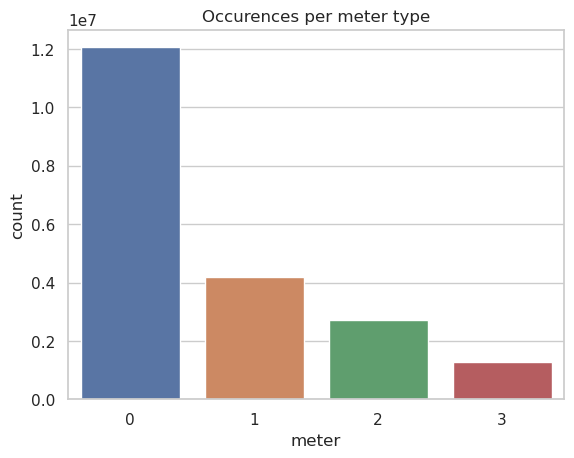

In [32]:
sns.countplot(data=train_full_raw, x='meter').set(title='Occurences per meter type')

**CONCLUSION**

We have a **majority of meter 0 data**

**Create variables**

In [33]:
# One hot encoding of meter
train_full_raw = one_hot(train_full_raw, 'meter')
test_full_raw = one_hot(test_full_raw, 'meter')

In [34]:
for i in range(0,4):
    train_full_raw[f'meter__{i}'] = train_full_raw[f'meter__{i}']*train_full_raw['meter_reading']
    test_full_raw[f'meter__{i}'] = test_full_raw[f'meter__{i}']*test_full_raw['meter_reading']

**Analysis**

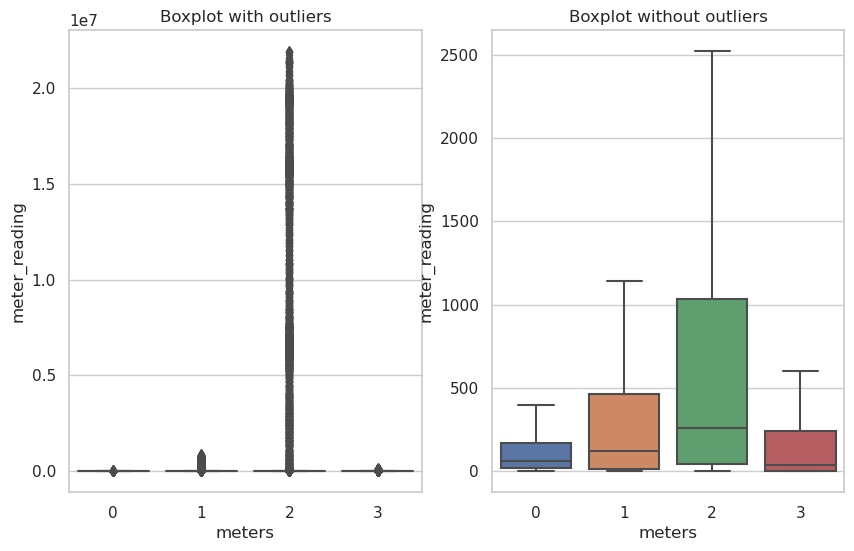

In [35]:
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.boxplot(x='meters', y='meter_reading', data=train_full_raw, ax=axes[0]).set(title='Boxplot with outliers');
sns.boxplot(x='meters', y='meter_reading', data=train_full_raw, ax=axes[1], showfliers=False).set(title='Boxplot without outliers');

In [36]:
train0 = train_full_raw[train_full_raw['meters']==0].groupby('timestamp').agg({'meter_reading':'mean'})
train1 = train_full_raw[train_full_raw['meters']==1].groupby('timestamp').agg({'meter_reading':'mean'})
train2 = train_full_raw[train_full_raw['meters']==2].groupby('timestamp').agg({'meter_reading':'mean'})
train3 = train_full_raw[train_full_raw['meters']==3].groupby('timestamp').agg({'meter_reading':'mean'})
train01 = train0.merge(train1, how='outer', left_index=True, right_index=True, suffixes=('_0', '_1'))
train012 = train01.merge(train2, how='outer', left_index=True, right_index=True, suffixes=('','_2'))
train0123 = train012.merge(train3, how='outer', left_index=True, right_index=True, suffixes=('_2','_3'))

Some **significant differences in terms of scale** between the different meter
- **meter 2 has peaks above 80000** meanwhile **the other meters are between 0 and 2500**
- **meter 2 has a huge difference in terms of min and max**, let see what is driving this

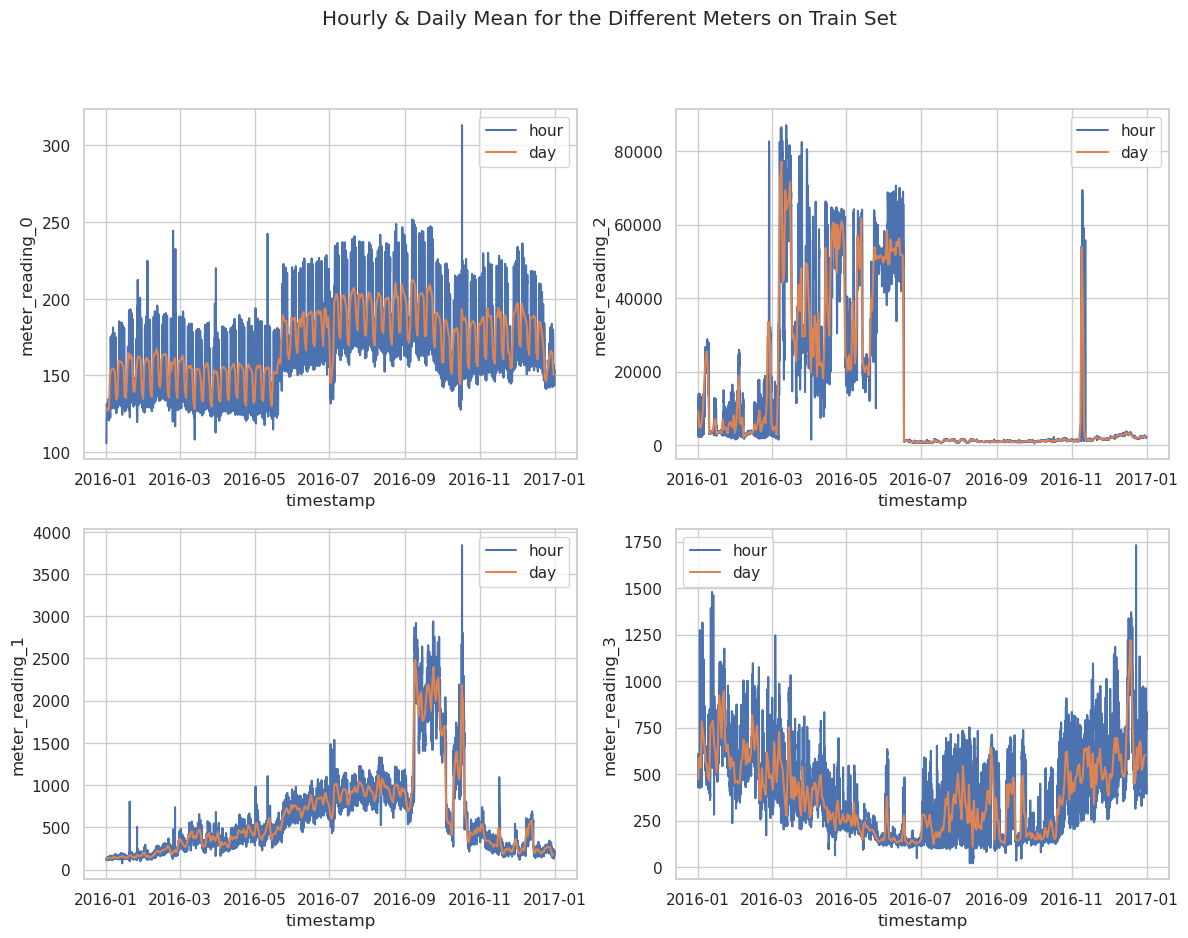

In [37]:
fig, axes = plt.subplots(2,2,figsize=(14, 10))
for i in range(0,4):
    sns.lineplot(data=train0123.reset_index(),y=f'meter_reading_{i}',x='timestamp',ax=axes[i%2][i//2], label='hour')
    sns.lineplot(data=train0123.resample('D').mean().reset_index(),y=f'meter_reading_{i}',x='timestamp',ax=axes[i%2][i//2], label='day')
fig.suptitle("Hourly & Daily Mean for the Different Meters on Train Set");

We can see that the **site 2 has the same shape as the global plot**, this is due to the fact that the scale (10^4) is way more important than the other site (10^2)

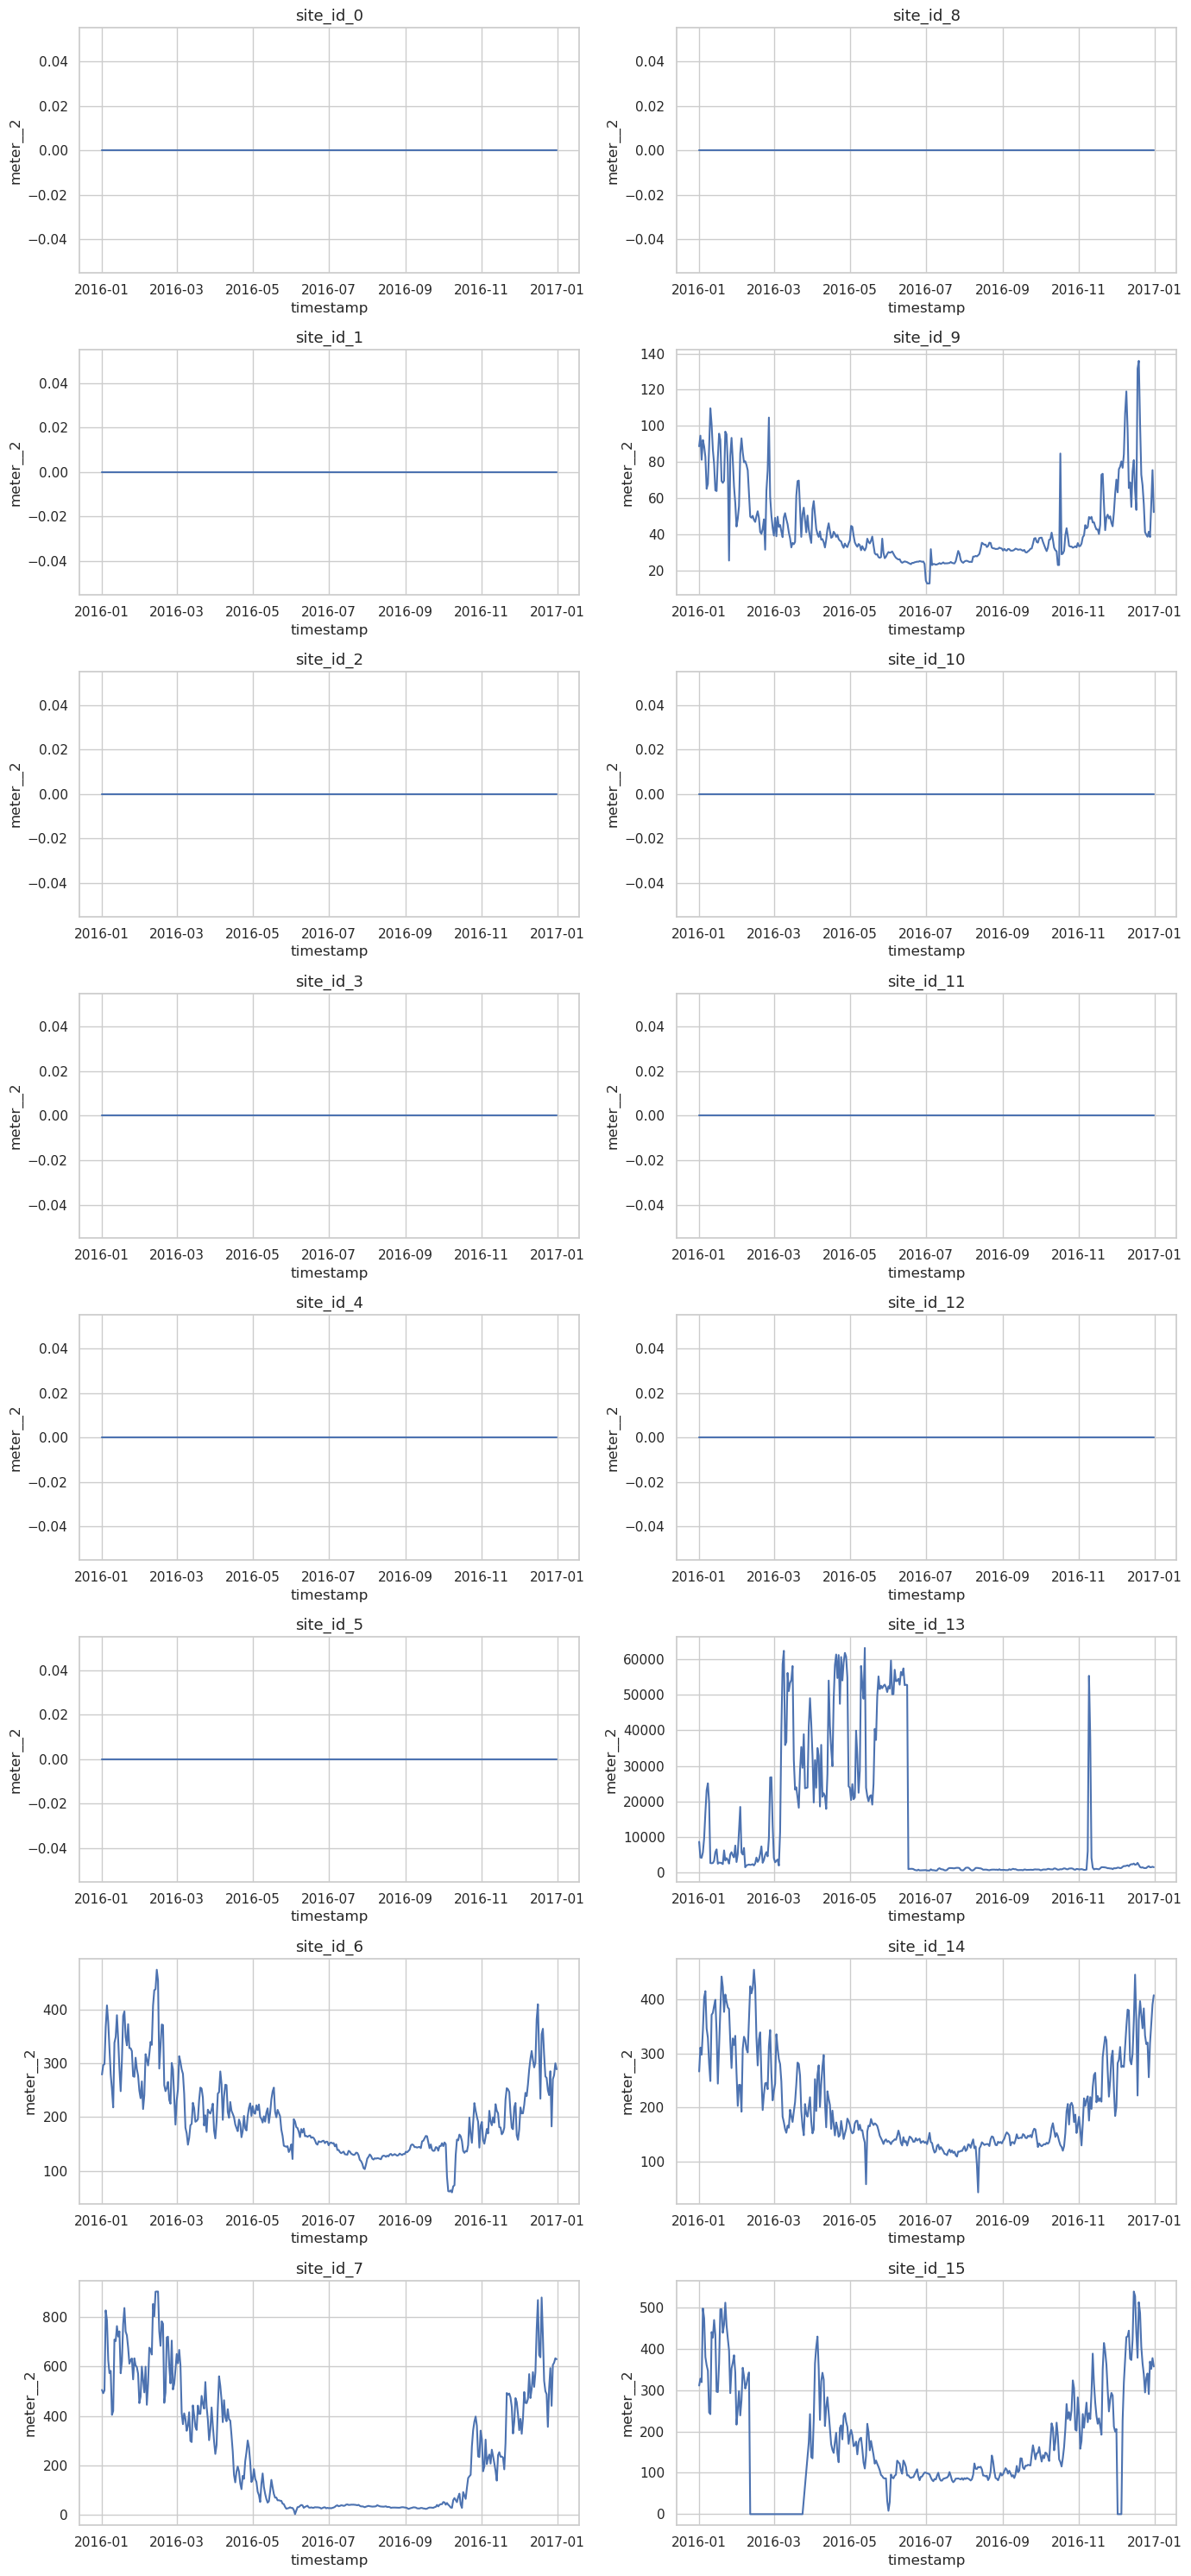

In [38]:
fig, axes = plt.subplots(8,2,figsize=(14, 30))
for i in range(0, 16):
    sns.lineplot(data=train_full_raw[train_full_raw['site_id']==i].set_index('timestamp').resample('D').mean().reset_index(),y=f'meter__2',x='timestamp',ax=axes[i%8][i//8]);
    axes[i%8][i//8].set_title(f'site_id_{i}', fontsize=13);
plt.tight_layout()    

Similarly, we can see that the **education buildings in site 13 has the same shape as the global plot**, this is due to the fact that the scale (10^4) is way more important than the other types of buildings (10^2)

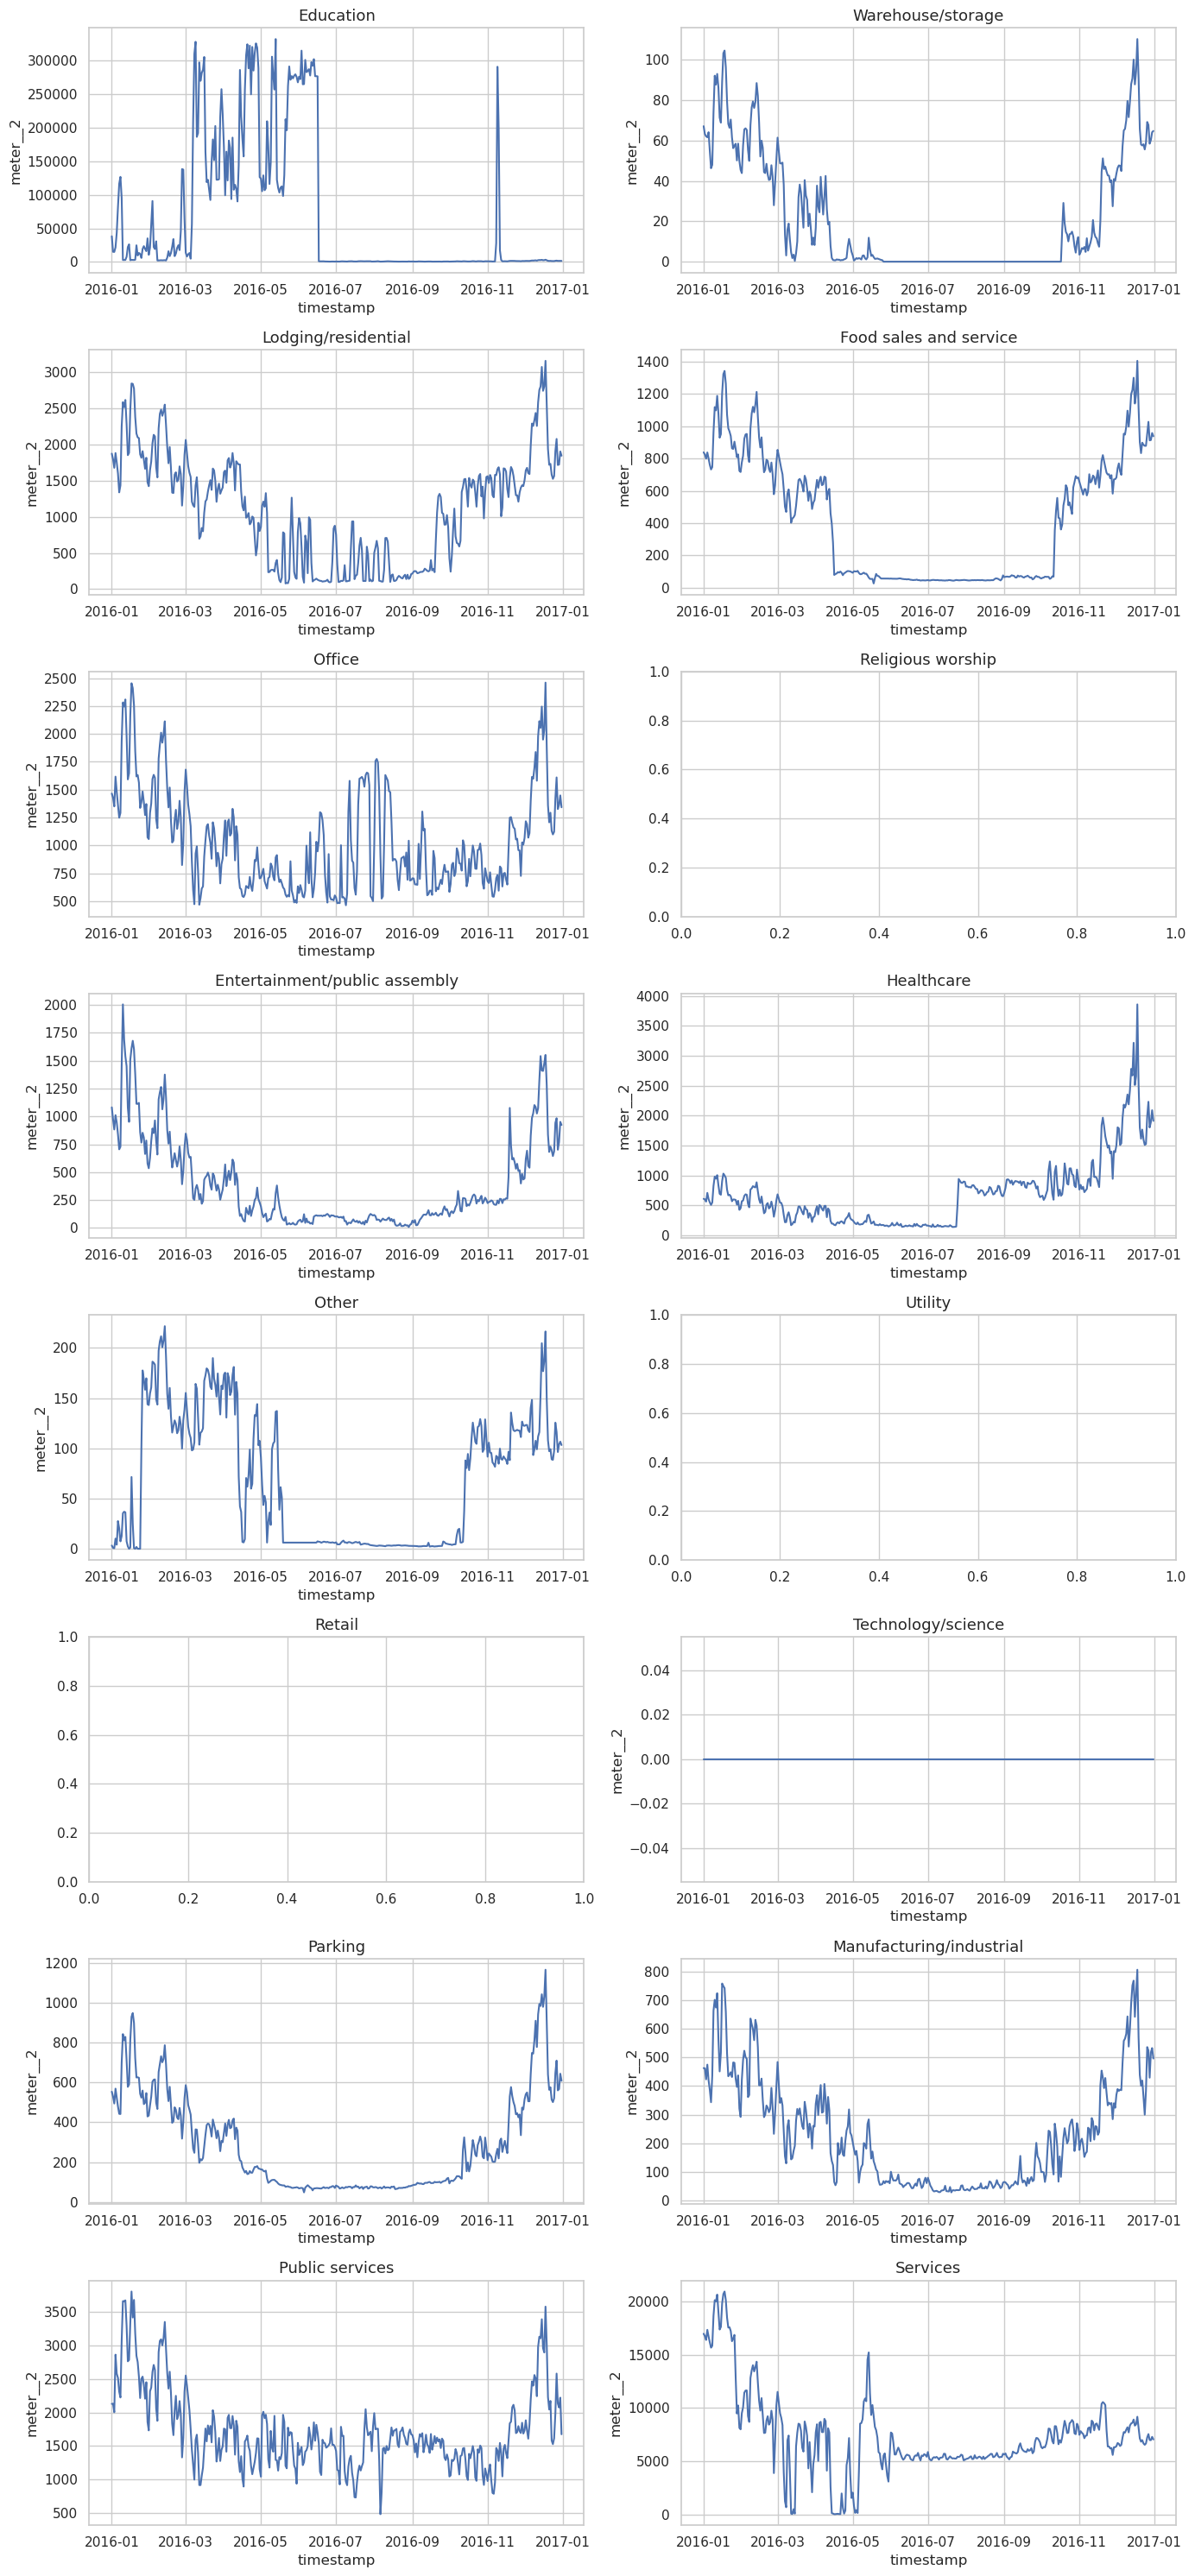

In [39]:
fig, axes = plt.subplots(8,2,figsize=(14, 30))
for idx, i in enumerate(train_full_raw['primary_use'].unique()):
    sns.lineplot(data=train_full_raw[(train_full_raw['primary_use']==i) & (train_full_raw['site_id']==13)].set_index('timestamp').resample('D').mean().reset_index(),y='meter__2',x='timestamp',ax=axes[idx%8][idx//8]);
    axes[idx%8][idx//8].set_title(f'{i}', fontsize=13);
plt.tight_layout()    

- We can see that the **building 1099 has the same trend as the global one**. On top of that, **its scale (10^7) is much greater than the other buildings (up to 10^4).**

- **This is probably an outlier**, hence we will delete the entries of meter 2 with building_id=1099 (at least for the analysis).

Let's see if building 1099 is still an outlier with the other meters

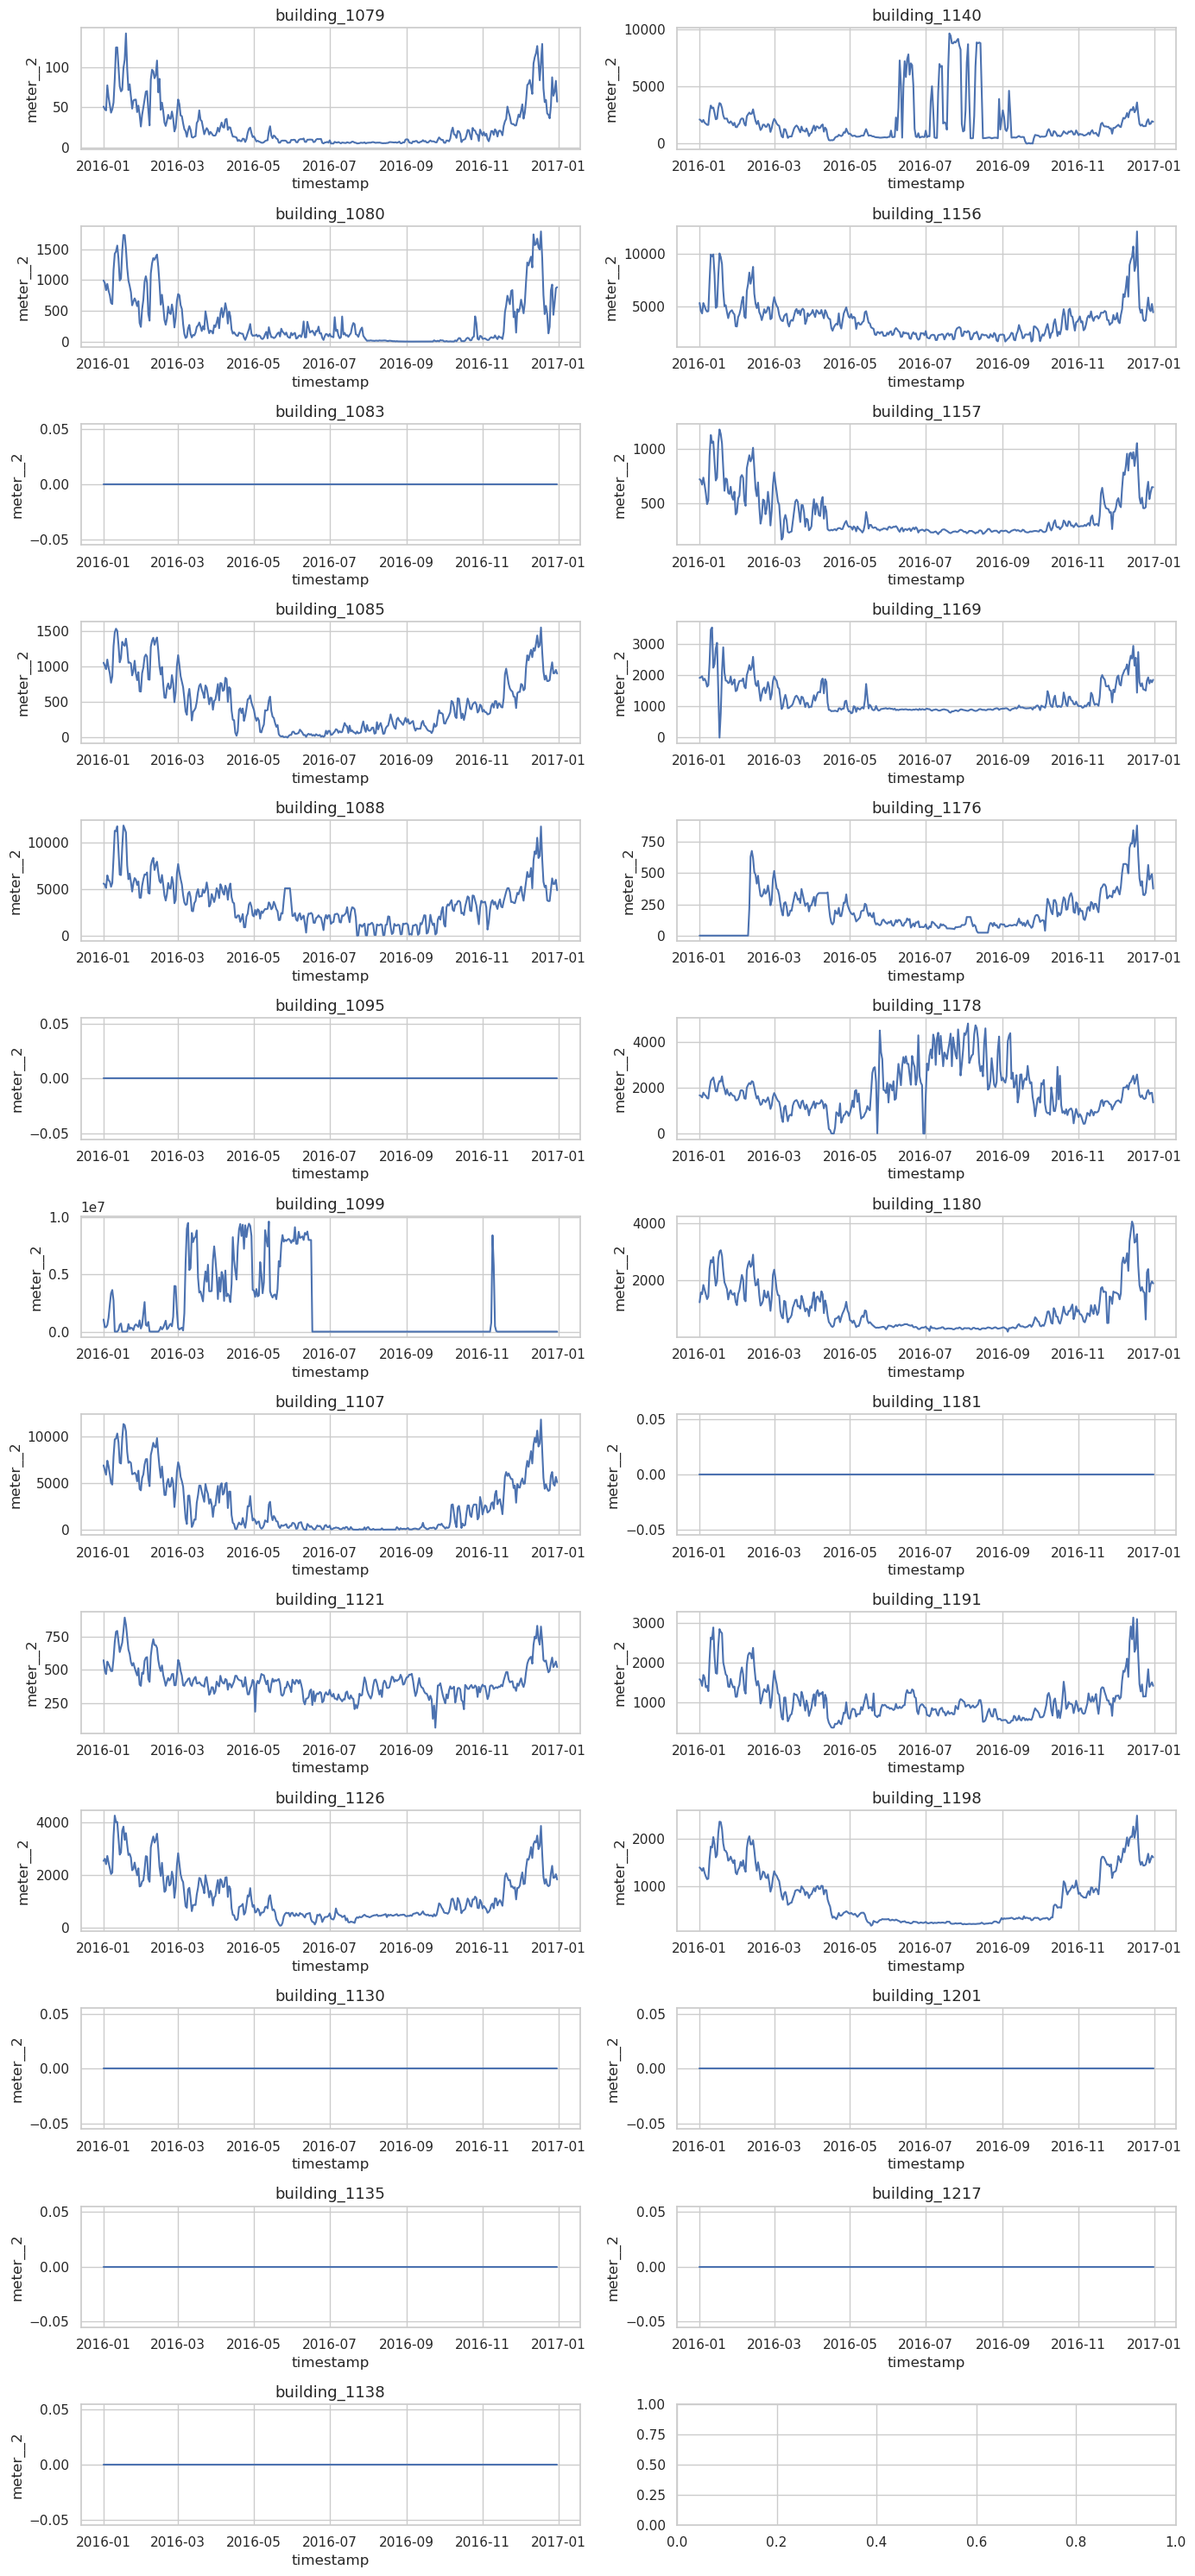

In [40]:
fig, axes = plt.subplots(13,2,figsize=(14, 30))
buildings = train_full_raw[(train_full_raw['site_id']==13) & (train_full_raw['primary_use']=='Education')]['building_id'].unique()
for idx, i in enumerate(buildings):
    sns.lineplot(data=train_full_raw[train_full_raw['building_id']==i].set_index('timestamp').resample('D').mean().reset_index(),y='meter__2',x='timestamp',ax=axes[idx%13][idx//13]);
    axes[idx%13][idx//13].set_title(f'building_{i}', fontsize=13);
plt.tight_layout()    

**No outlier for the other meters** so we will keep them in the data set

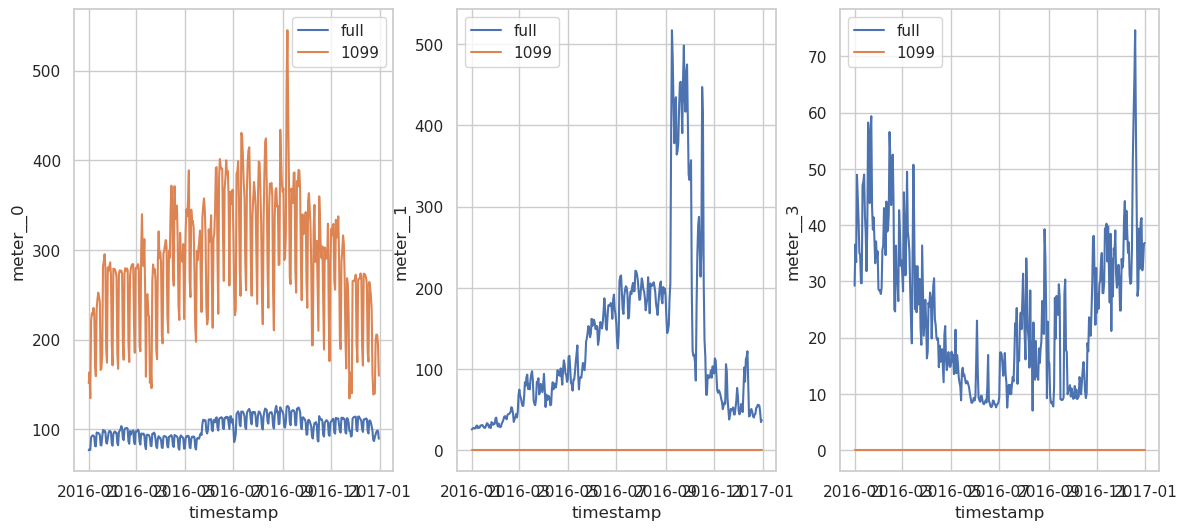

In [41]:
fig, axes = plt.subplots(1,3,figsize=(14, 6))
for idx,i in enumerate([0,1,3]):
    sns.lineplot(data=train_full_raw[train_full_raw['building_id']!=1099][['timestamp',f'meter__{i}']].set_index('timestamp').resample('D').mean(),y=f'meter__{i}',x='timestamp',ax=axes[idx], label='full')
    sns.lineplot(data=train_full_raw[train_full_raw['building_id']==1099][['timestamp',f'meter__{i}']].set_index('timestamp').resample('D').mean(),y=f'meter__{i}',x='timestamp',ax=axes[idx], label='1099')

**Taking off outliers**

In [42]:
train_full = train_full_raw[~((train_full_raw['building_id']==1099)&(train_full_raw['meters']==2))]
train_full_w_outliers = train_full_raw.copy()
test_full = test_full_raw.copy()
del test_full_raw, train_full_raw
gc.collect()

113234

### building_id

In [43]:
# Counting unique building ids
train_full['building_id'].nunique()

1449

__Historic for the buildings__

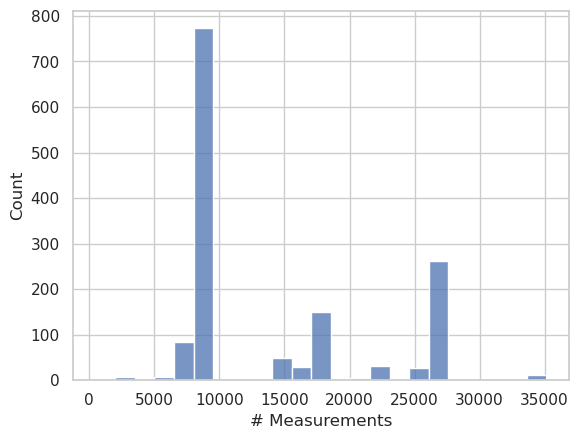

In [44]:
sns.histplot(train_full[['building_id']].value_counts()).set(xlabel='# Measurements', ylabel='Count');

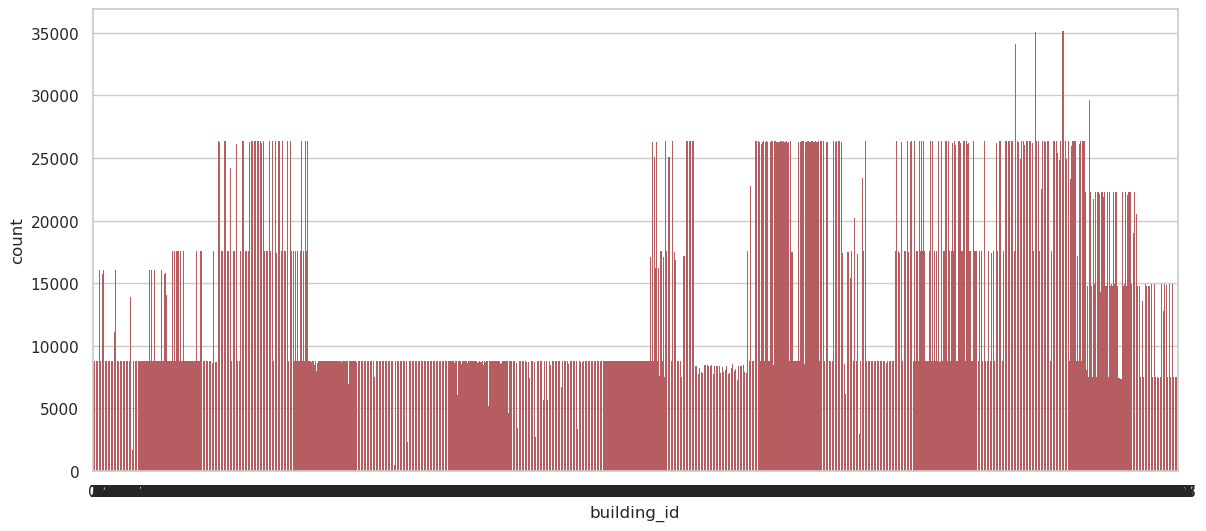

In [45]:
# Count measurements for each building ids
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.countplot(data = train_full[['building_id']], x='building_id',color='r', label='train')
plt.setp(axes.patches, linewidth=0);

**Conclusion**

There is mainly the **same number of measurements for each building id**

### timestamp

In [46]:
train__timestamp = train_full.groupby('building_id').agg({'timestamp':['max', 'min']})
train__timestamp.columns = train__timestamp.columns.get_level_values(0)
train__timestamp.reset_index(inplace=True)
train__timestamp.columns = ['building_id','max_time','min_time']
train__timestamp['delta'] = train__timestamp['max_time'] - train__timestamp['min_time']

In [47]:
train__timestamp[['delta','max_time','min_time']].value_counts().head(3)

delta              max_time             min_time           
365 days 23:00:00  2016-12-31 23:00:00  2016-01-01 00:00:00    1420
313 days 13:00:00  2016-12-31 23:00:00  2016-02-22 10:00:00       3
96 days 23:00:00   2016-04-06 23:00:00  2016-01-01 00:00:00       1
dtype: int64

In [48]:
test__timestamp = test_full.groupby('building_id').agg({'timestamp':['max', 'min']})
test__timestamp.columns = test__timestamp.columns.get_level_values(0)
test__timestamp.reset_index(inplace=True)
test__timestamp.columns = ['building_id','max_time','min_time']
test__timestamp['delta'] = test__timestamp['max_time'] - test__timestamp['min_time']

In [49]:
test__timestamp[['delta','max_time','min_time']].value_counts().head(3)

delta              max_time             min_time  
729 days 23:00:00  2018-12-31 23:00:00  2017-01-01    1449
dtype: int64

**CONCLUSION**

We have mainly: 
- **the 2016 historic for the train set**
- **the 2017 & 2018 historic for the test set** (two years following the train set)

### Site id

[Text(0.5, 1.0, 'test set')]

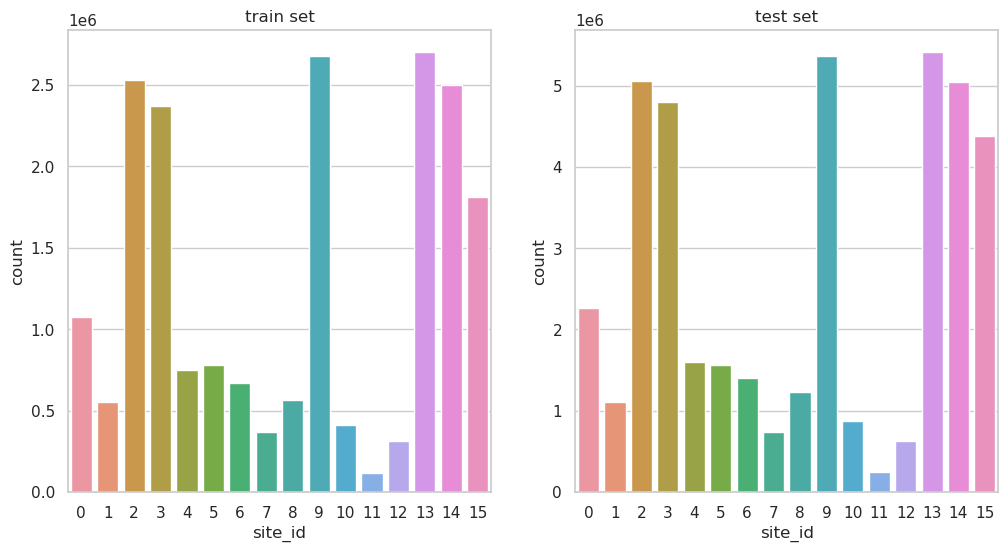

In [50]:
# Plotting the number of building ids per site id
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.countplot(data=train_full, x='site_id', ax=axes[0]).set(title='train set')
sns.countplot(data=test_full, x='site_id', ax=axes[1]).set(title='test set')

**CONCLUSION**

We have the **same distribution of buildings per site id** which is logical as the test set corresponds to the two following years of the train set

### primary_use

In [51]:
print('In train set:','\n','Null values:',round(train_full['primary_use'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['primary_use'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['primary_use'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['primary_use'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 0.0 % Nan values: 0.0 %
In test set: 
 Null values: 0.0 % Nan values: 0.0 %


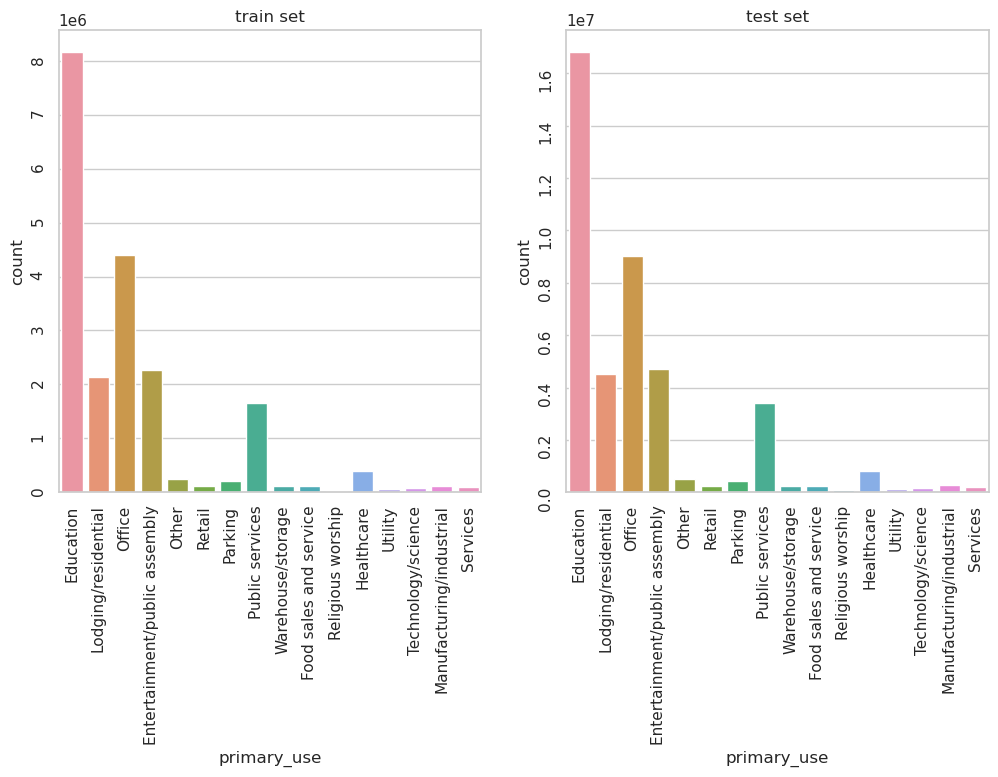

In [52]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.countplot(data=train_full, x='primary_use', ax=axes[0]).set(title='train set')
axes[0].tick_params(labelrotation=90);
sns.countplot(data=test_full, x='primary_use', ax=axes[1]).set(title='test set')
axes[1].tick_params(labelrotation=90);

**CONCLUSION**

We have a **majority of Education buildings**

### Square feet

In [53]:
print('In train set:','\n','Null values:',round(train_full['square_feet'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['square_feet'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['square_feet'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['square_feet'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 0.0 % Nan values: 0.0 %
In test set: 
 Null values: 0.0 % Nan values: 0.0 %


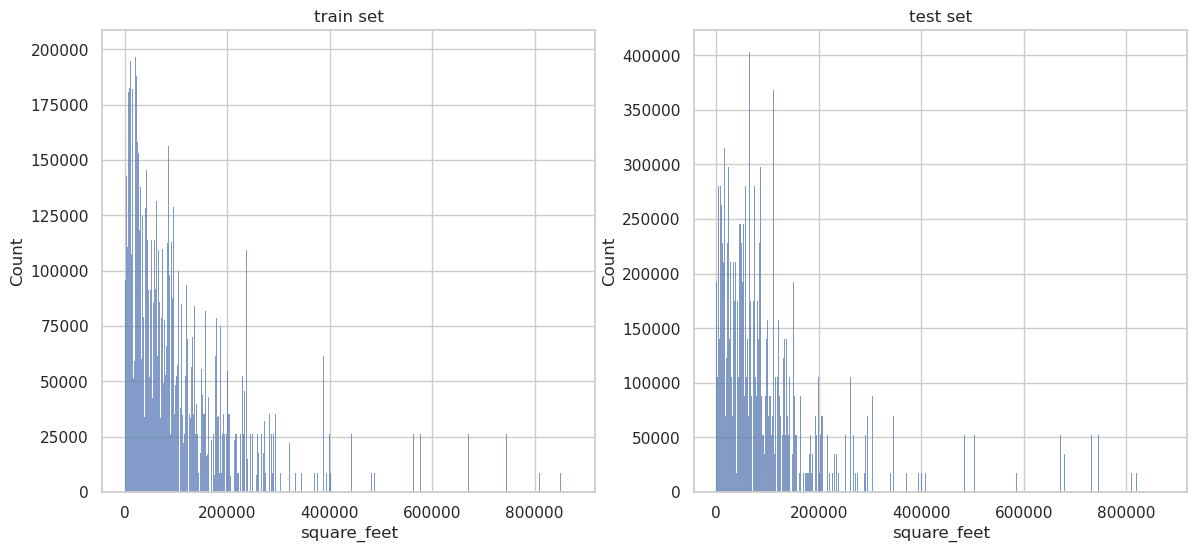

In [54]:
fig, axes = plt.subplots(1,2,figsize=(14, 6))
sns.histplot(data=train_full, x='square_feet',ax=axes[0]).set(title='train set');
sns.histplot(data=test_full, x='square_feet',ax=axes[1]).set(title='test set');

**CONCLUSION**

We have most of the **buildings having a surface lower than 200000 square feet**

### year_built

In [55]:
print('In train set:','\n','Null values:',round(train_full['year_built'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['year_built'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['year_built'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['year_built'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 59.97 % Nan values: 59.97 %
In test set: 
 Null values: 58.99 % Nan values: 58.99 %


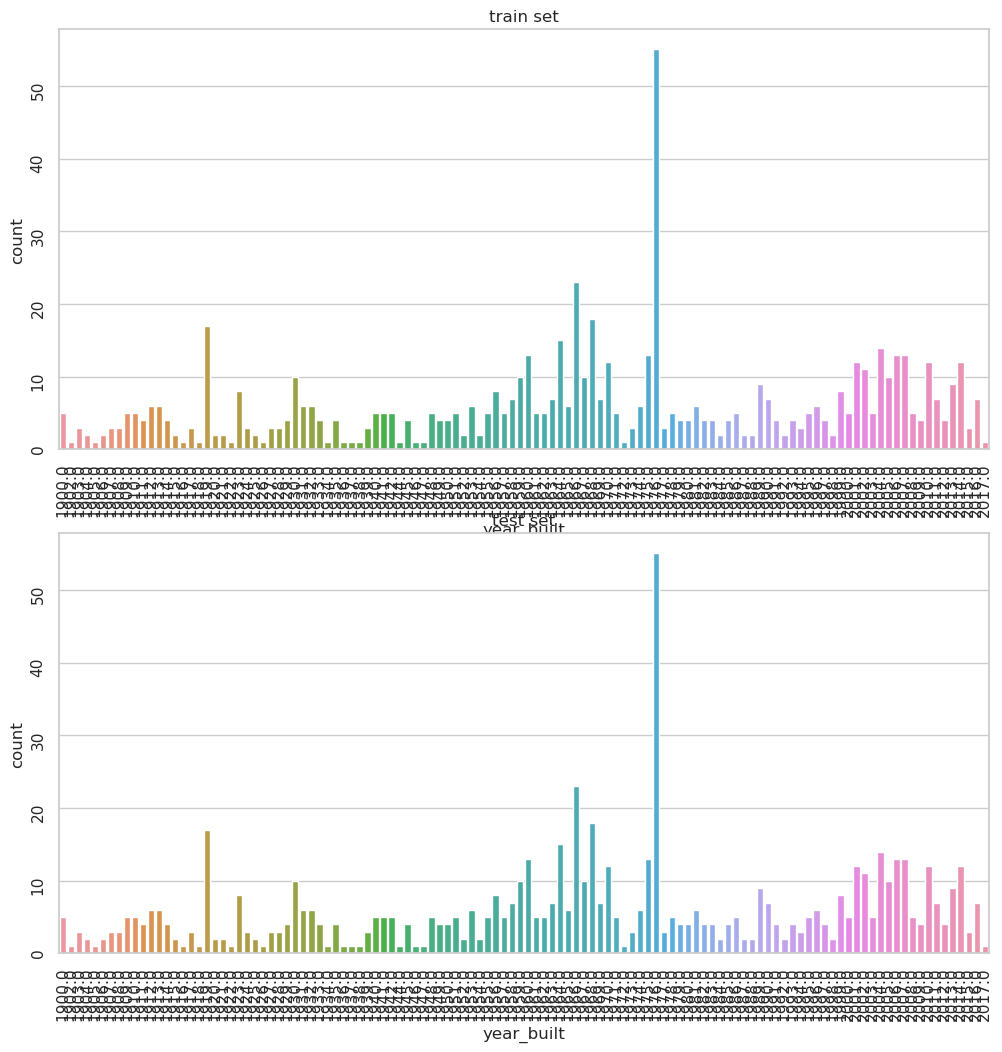

In [56]:
fig, axes = plt.subplots(2,1,figsize=(12,12))
sns.countplot(data=train_full.groupby(['year_built','building_id']).size().reset_index(), x='year_built', ax=axes[0]).set(title='train set');
axes[0].tick_params(labelrotation=90)
sns.countplot(data=test_full.groupby(['year_built','building_id']).size().reset_index(), x='year_built', ax=axes[1]).set(title='test set');
axes[1].tick_params(labelrotation=90)

**CONCLUSION**

We have:
- Approx **60% of missing values** for that feature
- There is no **year built significantly more frequent unless 1976**

### floor_count

In [57]:
print('In train set:','\n','Null values:',round(train_full['floor_count'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['floor_count'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['floor_count'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['floor_count'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 82.65 % Nan values: 82.65 %
In test set: 
 Null values: 82.61 % Nan values: 82.61 %


**CONCLUSION**

We have:
- Approx. **82% of missing values** for that feature
- This feature won't be used as there are too many missing values

### air_temperature

In [58]:
print('In train set:','\n','Null values:',round(train_full['air_temperature'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['air_temperature'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['air_temperature'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['air_temperature'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 0.48 % Nan values: 0.48 %
In test set: 
 Null values: 0.53 % Nan values: 0.53 %


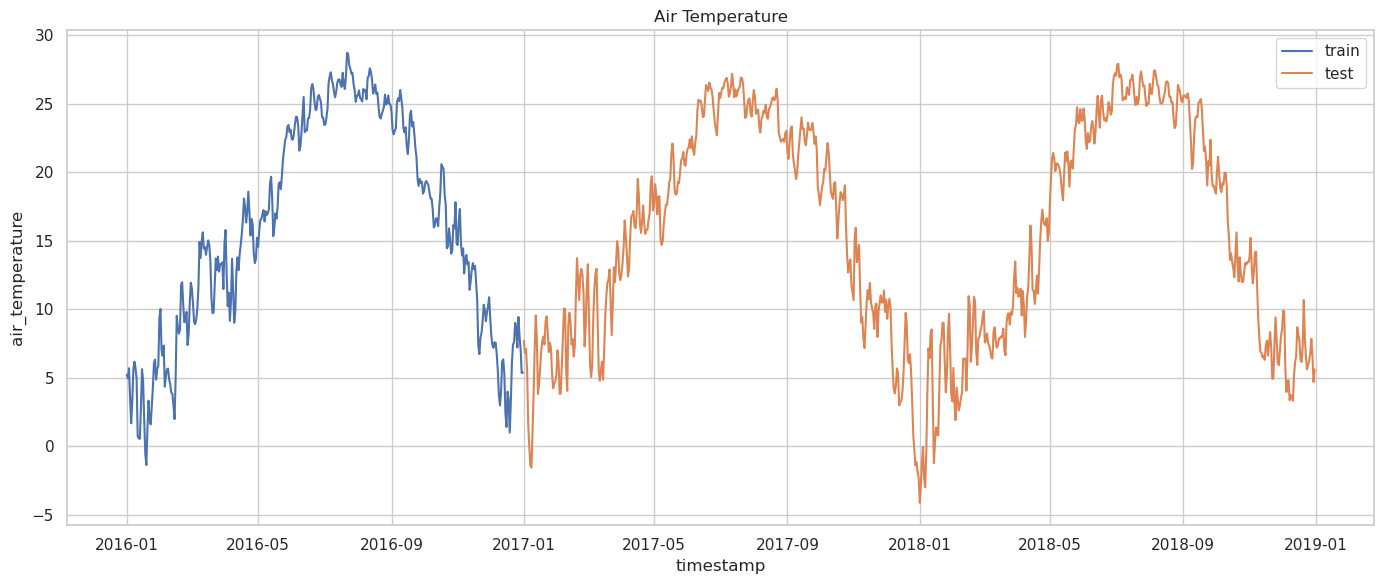

In [59]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='air_temperature',x='timestamp', label='train').set(title='Air Temperature');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='air_temperature',x='timestamp', label='test');
plt.tight_layout()

**CONCLUSION**

We have:
- **less than 1% of missing values for that feature**
- the **same seasonality for both train and test sets**

### cloud_coverage

In [60]:
print('In train set:','\n','Null values:',round(train_full['cloud_coverage'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['cloud_coverage'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['cloud_coverage'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['cloud_coverage'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 43.65 % Nan values: 43.65 %
In test set: 
 Null values: 46.87 % Nan values: 46.87 %


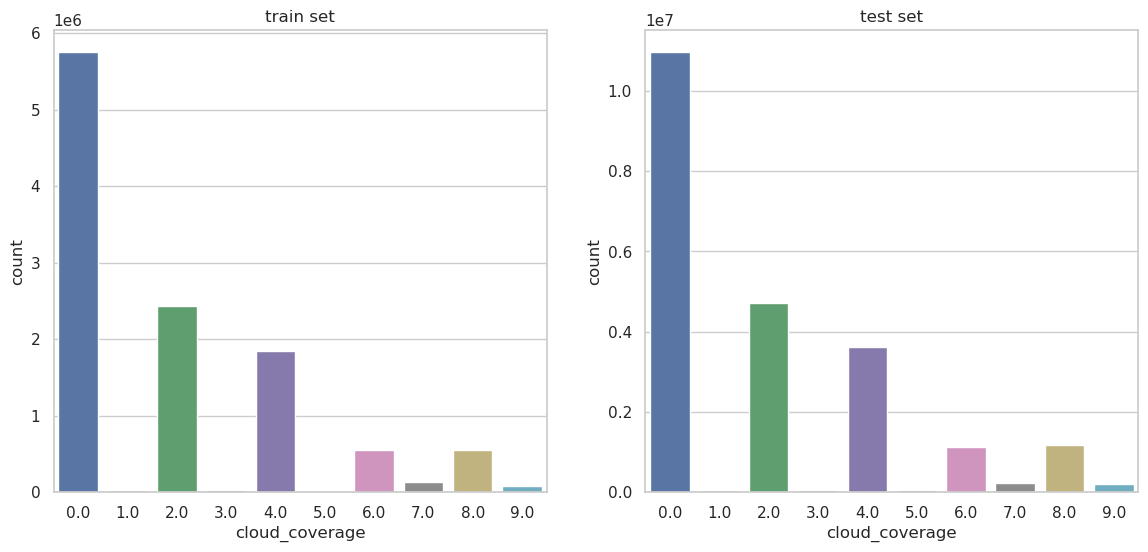

In [61]:
fig, axes = plt.subplots(1,2,figsize=(14, 6))
sns.countplot(data=train_full, x='cloud_coverage',ax=axes[0]).set(title='train set');
sns.countplot(data=test_full, x='cloud_coverage',ax=axes[1]).set(title='test set');

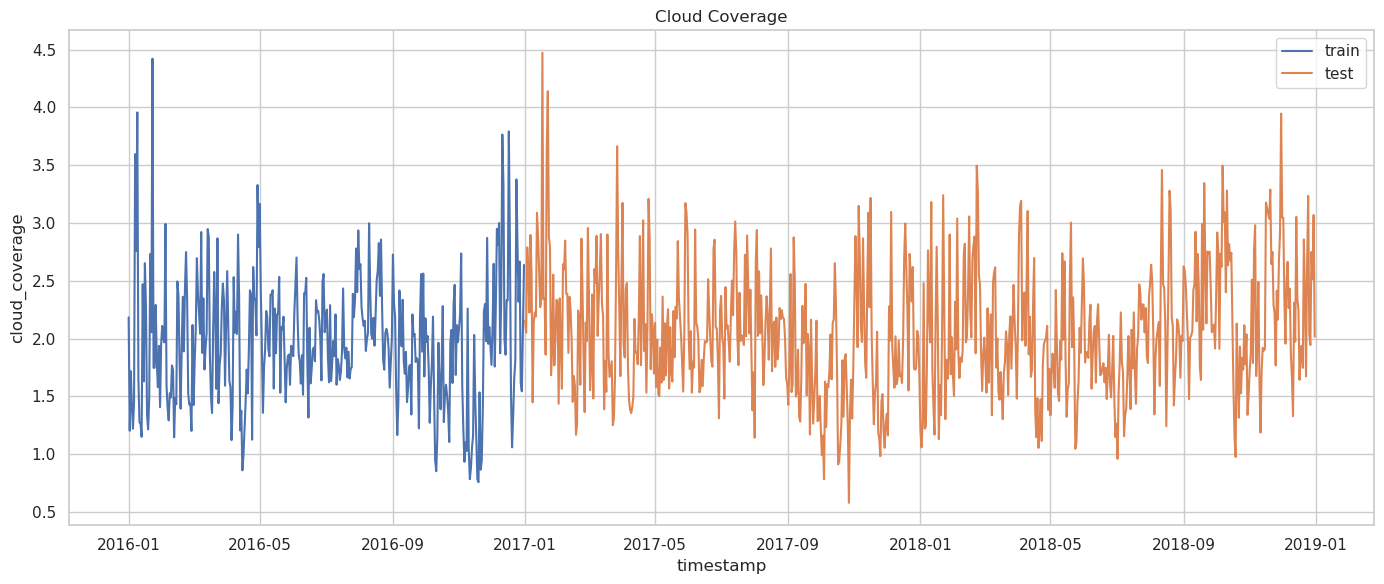

In [62]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='cloud_coverage',x='timestamp', label='train').set(title='Cloud Coverage');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='cloud_coverage',x='timestamp', label='test');
plt.tight_layout()

**CONCLUSION**

We have:
- appox. **46% of missing values**
- the **same distribution and trend between train and test set**

### dew_temperature

In [63]:
print('In train set:','\n','Null values:',round(train_full['dew_temperature'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['dew_temperature'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['dew_temperature'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['dew_temperature'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 0.5 % Nan values: 0.5 %
In test set: 
 Null values: 0.63 % Nan values: 0.63 %


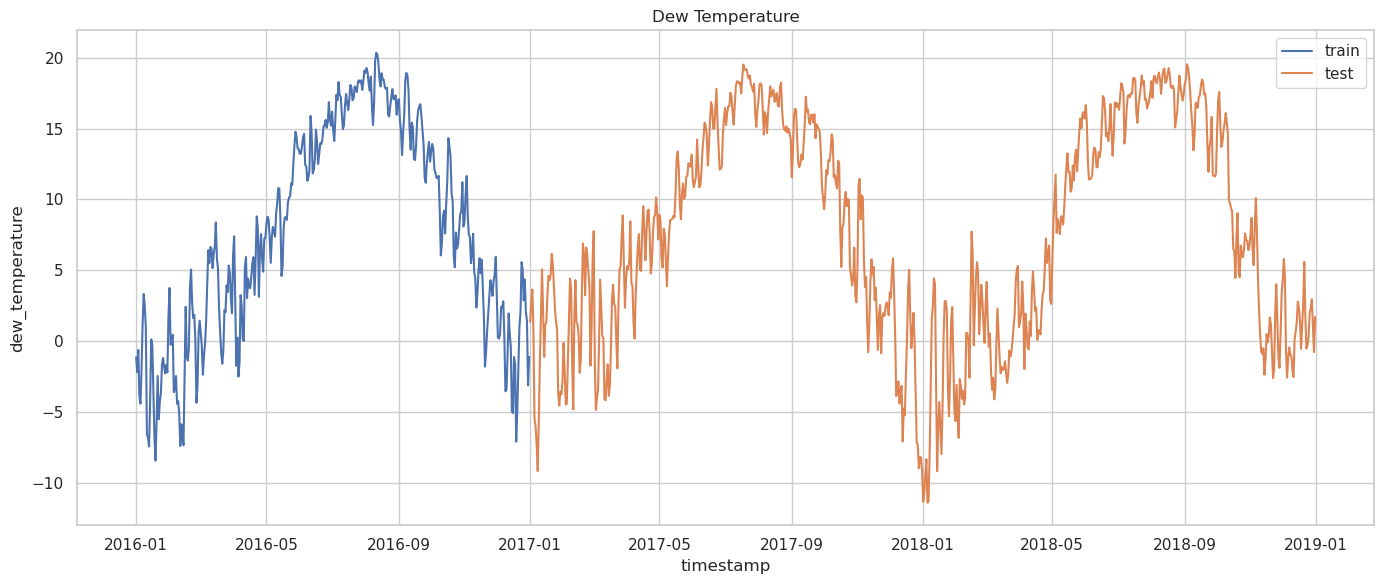

In [64]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='dew_temperature',x='timestamp', label='train').set(title='Dew Temperature');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='dew_temperature',x='timestamp', label='test');
plt.tight_layout()

**CONCLUSION**

We have:
- **less than 1% of missing values for that feature**
- the **same seasonality for both train and test sets**

### precip_depth_1_hr

In [65]:
print('In train set:','\n','Null values:',round(train_full['precip_depth_1_hr'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['precip_depth_1_hr'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['precip_depth_1_hr'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['precip_depth_1_hr'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 18.55 % Nan values: 18.55 %
In test set: 
 Null values: 18.71 % Nan values: 18.71 %


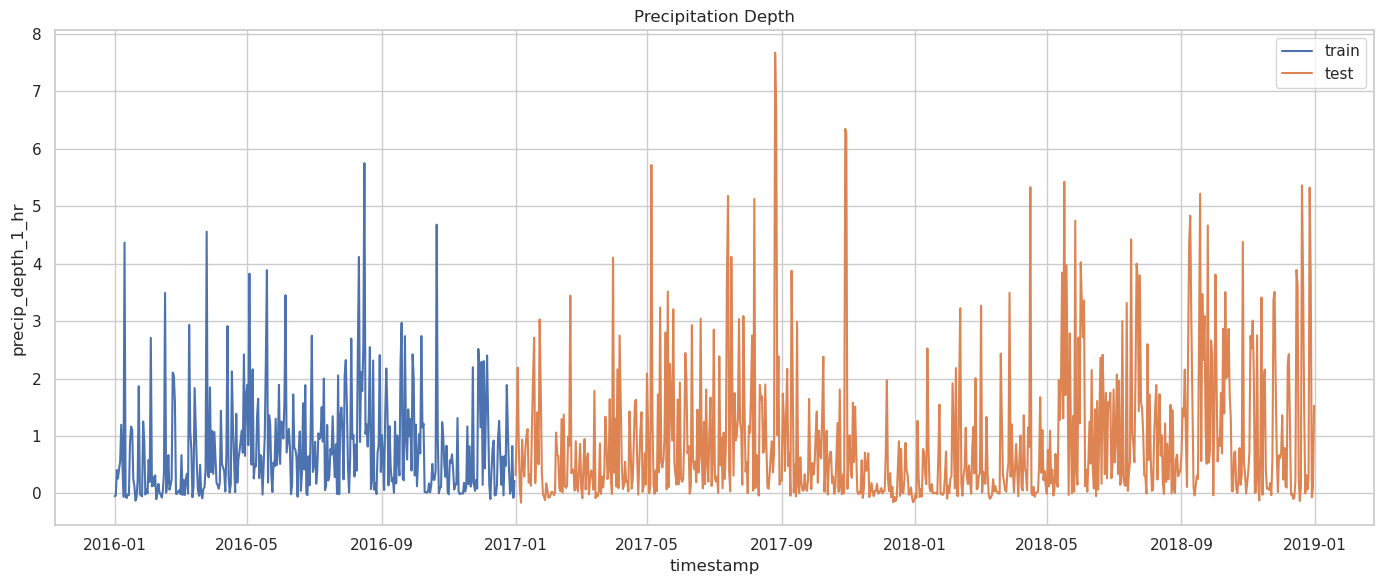

In [66]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

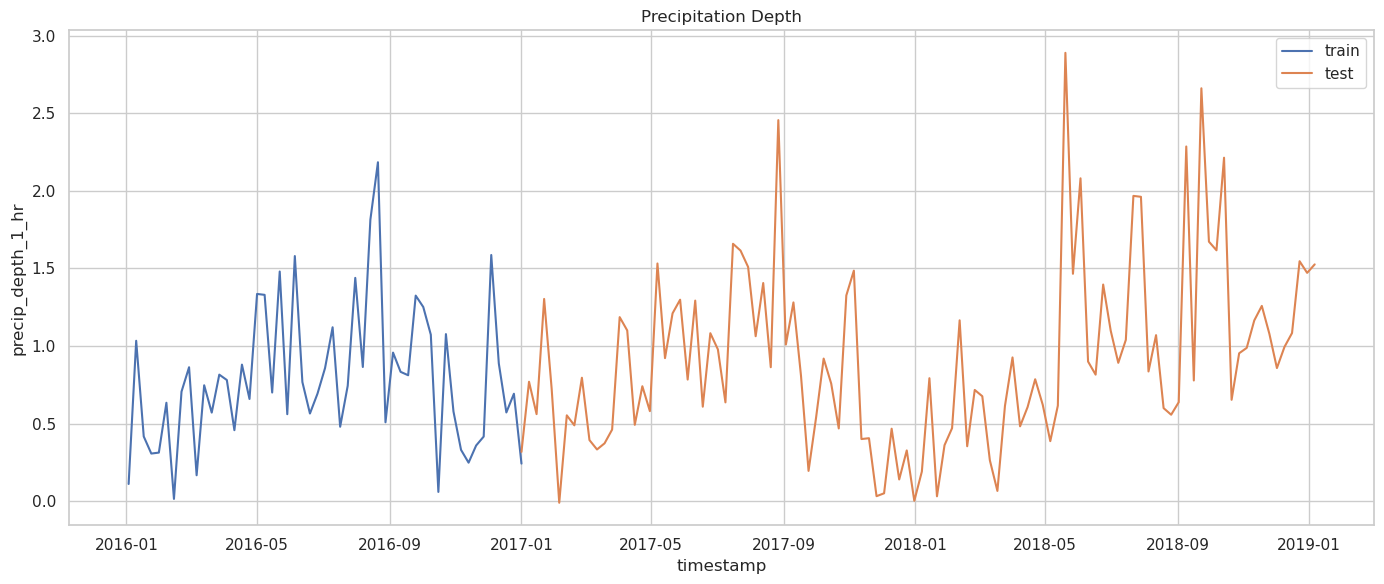

In [67]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('W').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_full.set_index('timestamp').resample('W').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

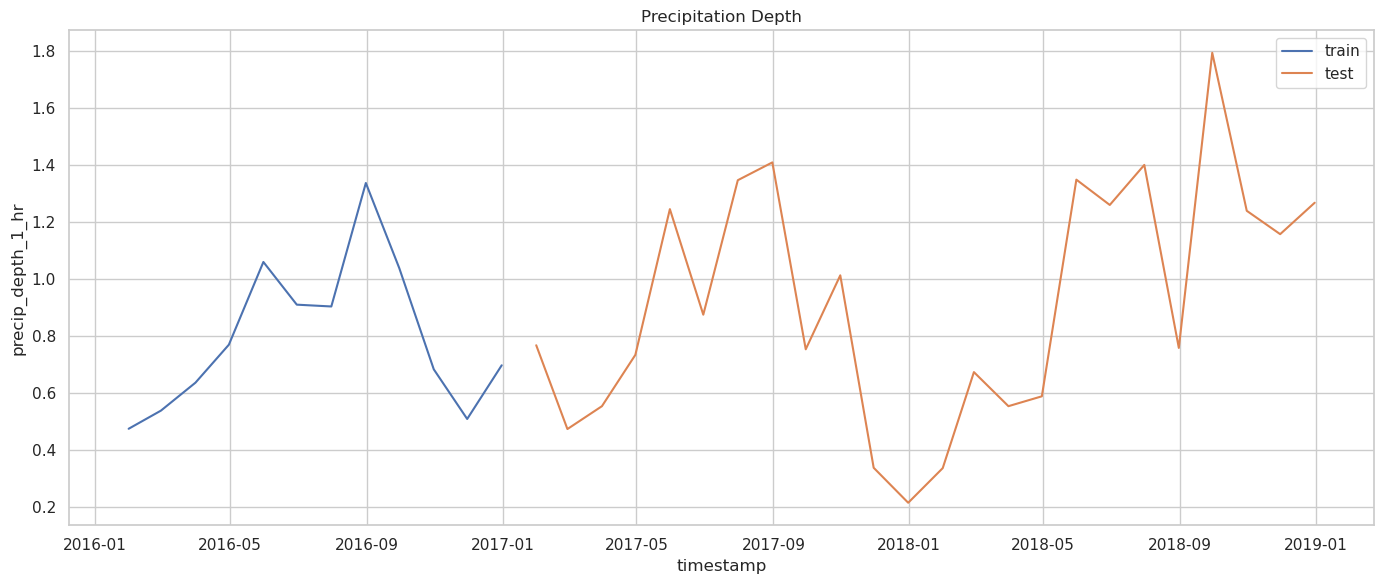

In [68]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('M').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_full.set_index('timestamp').resample('M').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

**CONCLUSION**

We have:
- Appox. **20% of missing values for that feature**
- the **same seasonality between 2016 and 2017 but a greater precipitation depth for late 2018**

### Sea_level_pressure

In [69]:
print('In train set:','\n','Null values:',round(train_full['sea_level_pressure'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['sea_level_pressure'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['sea_level_pressure'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['sea_level_pressure'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 6.09 % Nan values: 6.09 %
In test set: 
 Null values: 6.04 % Nan values: 6.04 %


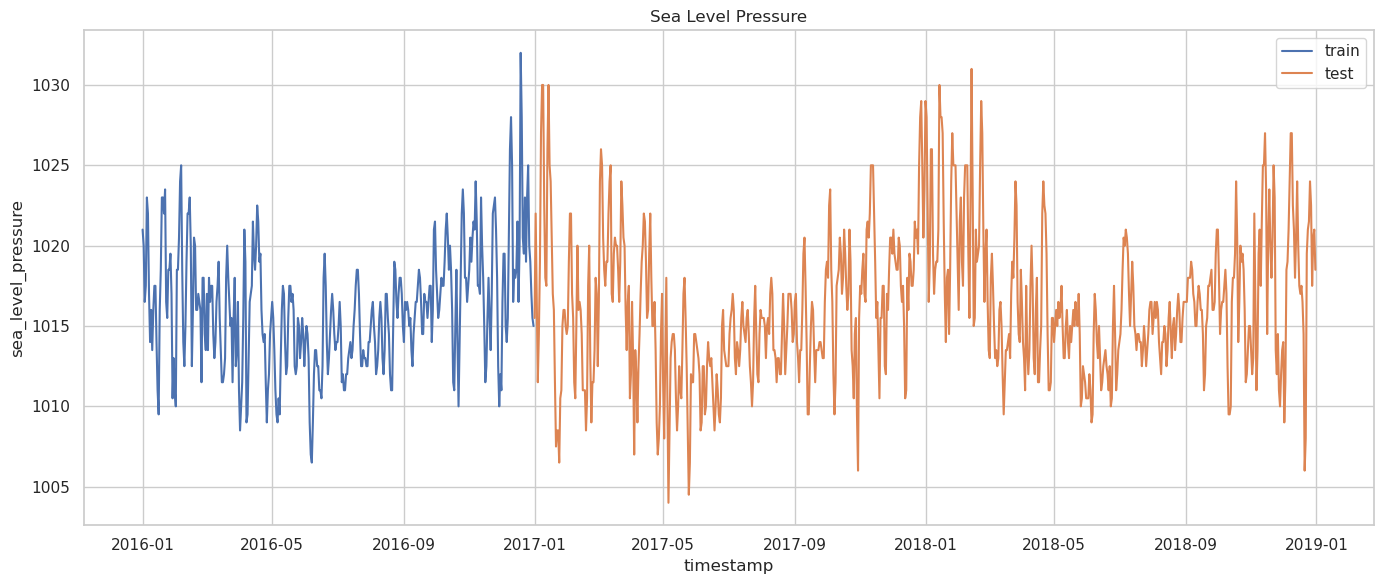

In [70]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='train').set(title='Sea Level Pressure');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='test');
plt.tight_layout()

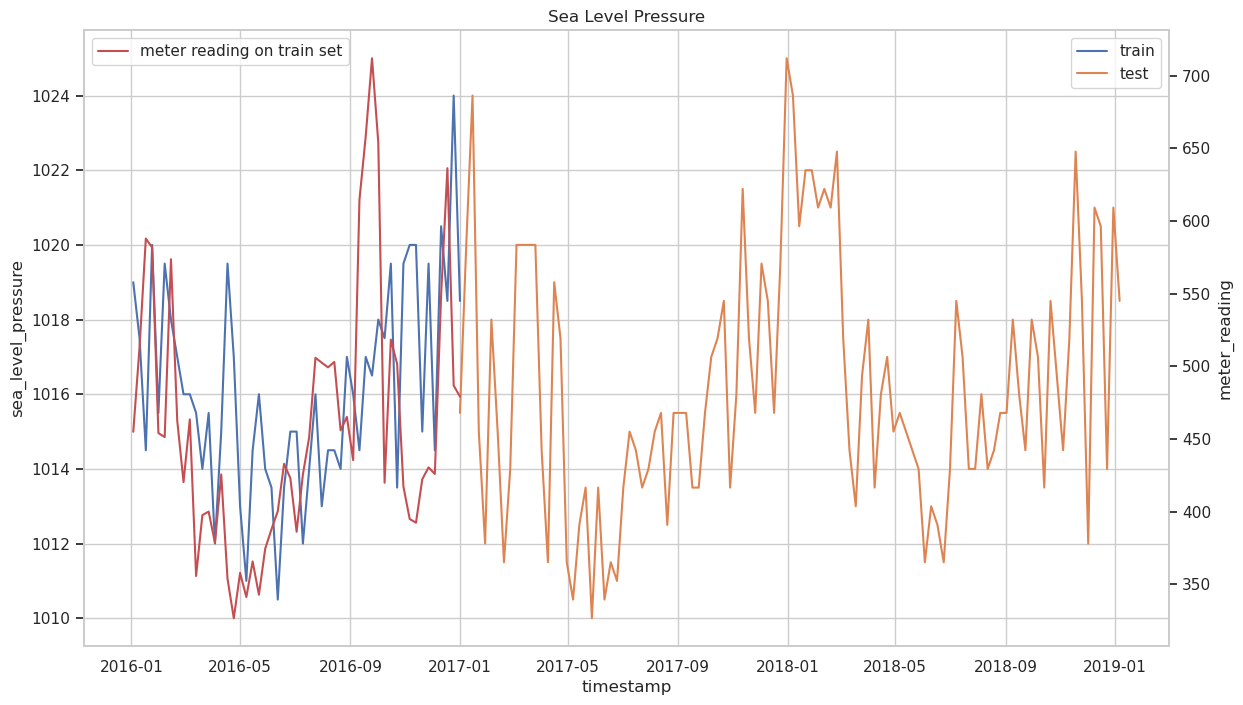

In [71]:
fig,axes = plt.subplots(1,1,figsize=(14, 8))
tr = sns.lineplot(data=train_full.set_index('timestamp').resample('W').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='train').set(title='Sea Level Pressure');
tt = sns.lineplot(data=test_full.set_index('timestamp').resample('W').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='test');
ax2 = axes.twinx()
ax2.grid(False);
mr = sns.lineplot(data=train_full.set_index('timestamp').resample('W').mean().reset_index(),y='meter_reading',x='timestamp', color='r', label='meter reading on train set');
axes.legend(loc=0);
ax2.legend(loc=2);

**CONCLUSION**

We have:
- Approx. **5% of missing values for that feature**
- the **same seasonality for both train and test sets**
- There is **positive correlation between sea level pressure and meter reading**

### wind_direction

In [72]:
print('In train set:','\n','Null values:',round(train_full['wind_direction'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['wind_direction'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['wind_direction'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['wind_direction'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 7.17 % Nan values: 7.17 %
In test set: 
 Null values: 7.14 % Nan values: 7.14 %


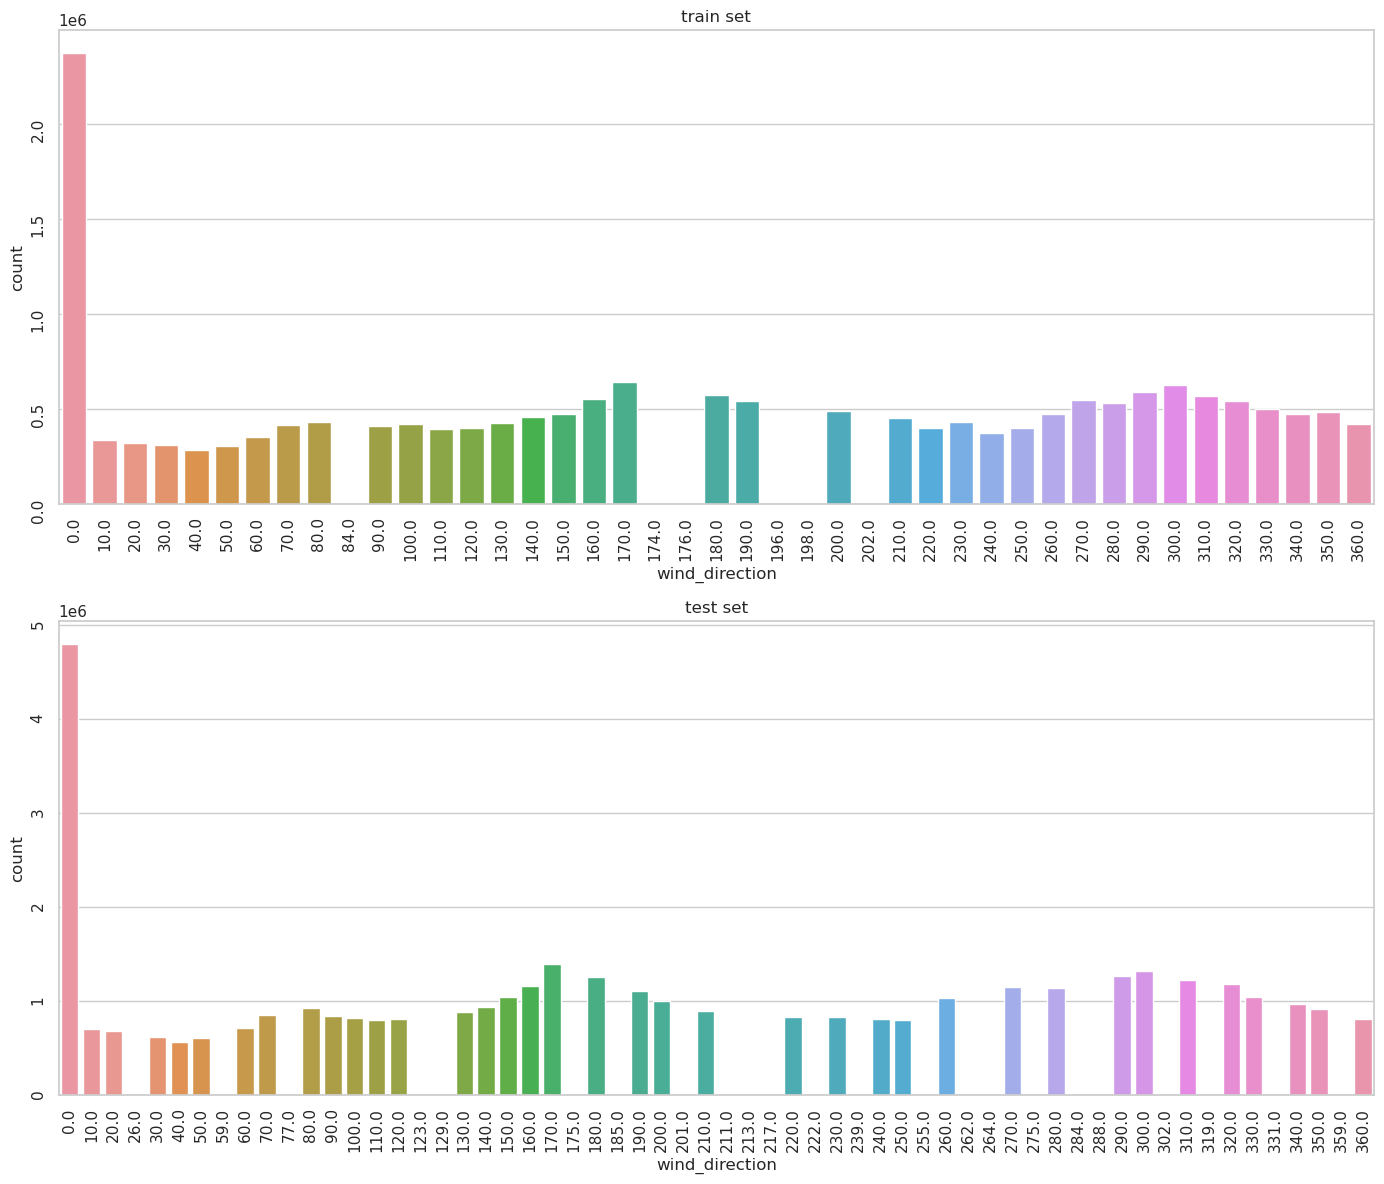

In [73]:
fig, axes = plt.subplots(2,1,figsize=(14, 12))
sns.countplot(data=train_full.sort_values(by='wind_direction'), x='wind_direction',ax=axes[0]).set(title='train set');
axes[0].tick_params(labelrotation=90)
sns.countplot(data=test_full.sort_values(by='wind_direction'), x='wind_direction',ax=axes[1]).set(title='test set');
axes[1].tick_params(labelrotation=90)
plt.tight_layout()

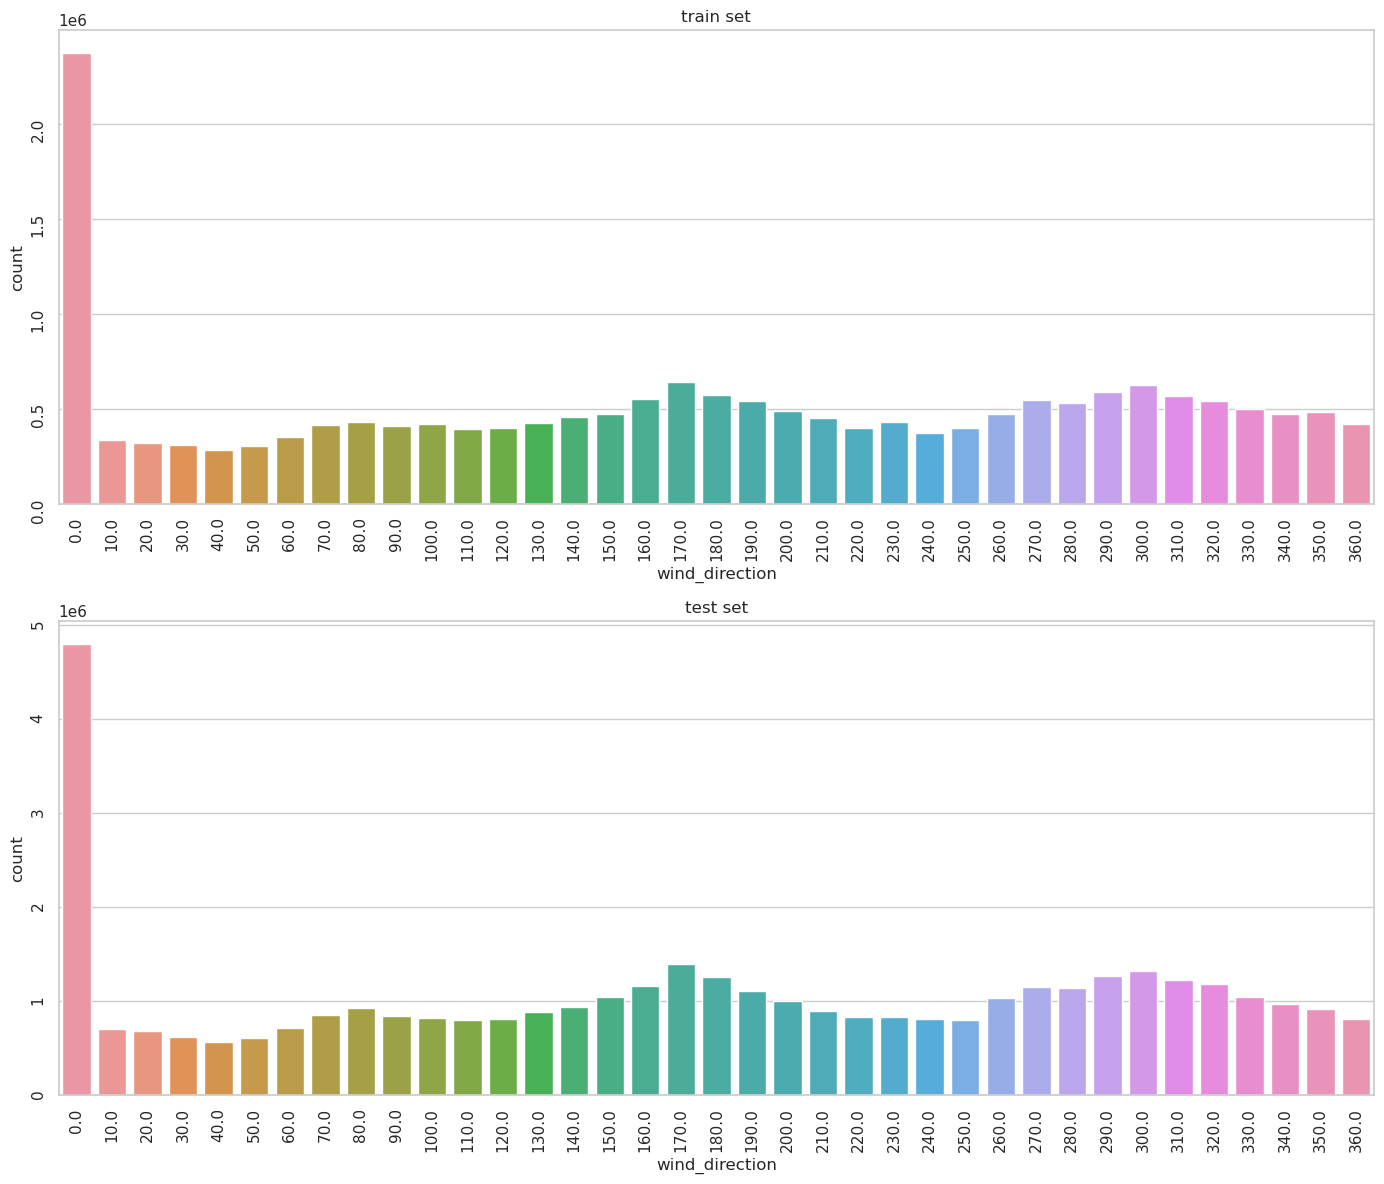

In [74]:
fig, axes = plt.subplots(2,1,figsize=(14, 12))
sns.countplot(data=train_full[train_full['wind_direction']%10==0], x='wind_direction',ax=axes[0]).set(title='train set');
axes[0].tick_params(labelrotation=90)
sns.countplot(data=test_full[test_full['wind_direction']%10==0], x='wind_direction',ax=axes[1]).set(title='test set');
axes[1].tick_params(labelrotation=90)
plt.tight_layout()

**CONCLUSION**

We have:
- approx. **7% of missing values for that feature**
- the **same distribution for both train and test set**
- wind direction = 0 is significantly more frequent, this is most probably due to lack of values than actual value = 0

### wind_speed

In [75]:
print('In train set:','\n','Null values:',round(train_full['wind_speed'].isnull().sum()*100/len(train_full),2),'%', 'Nan values:',round(train_full['wind_speed'].isna().sum()*100/len(train_full),2),'%')
print('In test set:','\n','Null values:',round(test_full['wind_speed'].isnull().sum()*100/len(test_full),2),'%', 'Nan values:',round(test_full['wind_speed'].isna().sum()*100/len(test_full),2),'%')


In train set: 
 Null values: 0.71 % Nan values: 0.71 %
In test set: 
 Null values: 0.72 % Nan values: 0.72 %


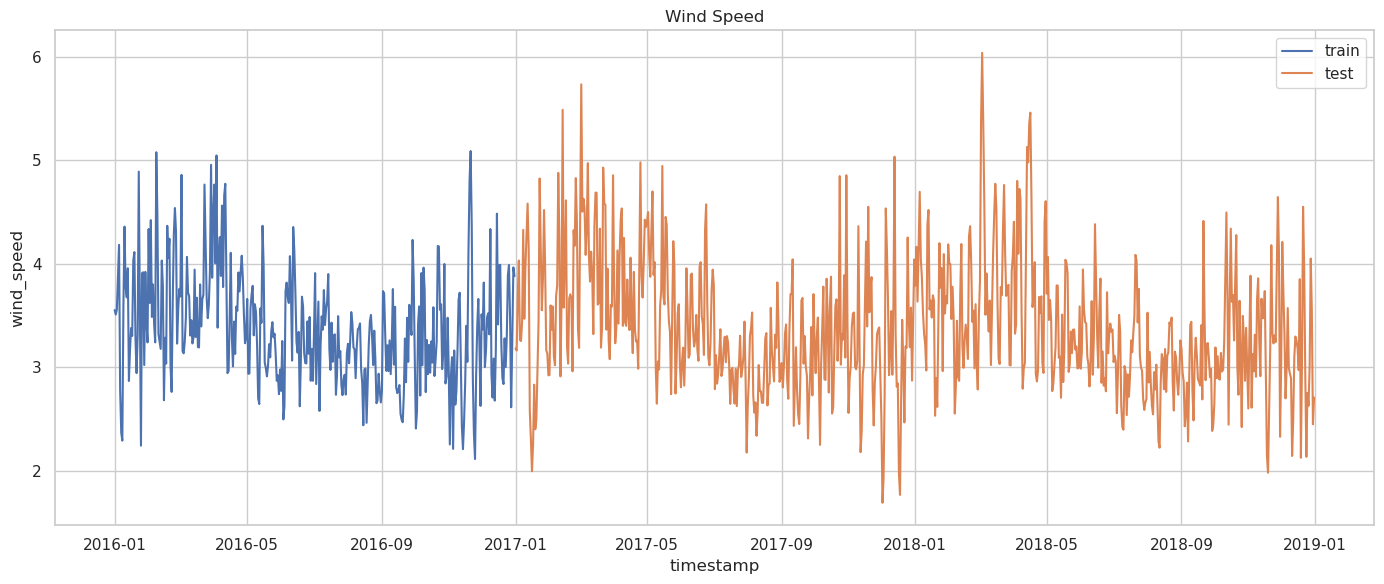

In [76]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('D').mean().reset_index(),y='wind_speed',x='timestamp', label='train').set(title='Wind Speed');
sns.lineplot(data=test_full.set_index('timestamp').resample('D').mean().reset_index(),y='wind_speed',x='timestamp', label='test');
plt.tight_layout()

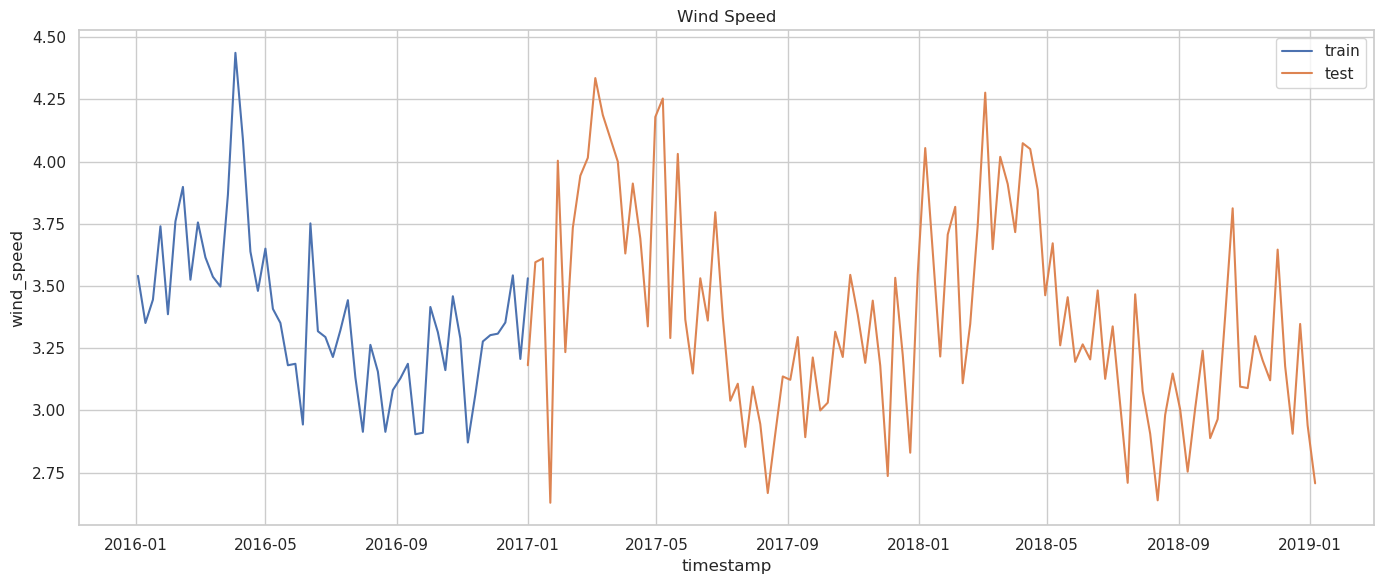

In [77]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_full.set_index('timestamp').resample('W').mean().reset_index(),y='wind_speed',x='timestamp', label='train').set(title='Wind Speed');
sns.lineplot(data=test_full.set_index('timestamp').resample('W').mean().reset_index(),y='wind_speed',x='timestamp', label='test');
plt.tight_layout()

**CONCLUSION**

We have:
- **Less than 1% of missing values for that feature**
- the **same seasonality for both train and test sets**

## Save modified train and test sets

In [78]:
train_full.to_csv('train_full_wo_outliers.csv',index=False)
train_full_w_outliers.to_csv('train_full_w_outliers.csv',index=False) # if we want to keep outliers
test_full.to_csv('test_full.csv',index=False)

In [79]:
del train_full, train_full_w_outliers, test_full
gc.collect()

186470

## General Conclusion about EDA

This EDA brought us some insights:
- train set is the **2016 historic of approx. 1400 buildings** and **test set is the 2017 & 2018 historic of those same buildings**

Consequently, we have for both train and test sets: 
- **the same trends, seasonality and distribution**
- the **same proportion of missing values** with, as **features with most missing values**:
    - `floor count` (approx. 80% of missing values)
    - `year built` (approx. 60% of missing values)
    - `cloud coverage` (approx. 50% of missing values)
    - `precip depth 1hr` (approx. 20% of missing values)
    - `wind direction` (approx. 8% of missing values)
    - `see level pressure` (approx. 5% of missing values)

 
On top of that, we saw that there are **some outliers linked to building id 1099 for meter 2**. This might be due to measurement errors in terms of sensors or unit of measure. 
On a regular basis, we should delete these outliers but as test set is the measurements for the 2 following years, it might be difficult to delete those. 
We will do the two cases, **train with those outliers** and **train without those outliers**. If training with those outliers, **it is mandatory to scale** `meter reading`.


**Improvements for EDA**
- For meteorolical data, make a split by site id
- Add meter reading to plot to visualize potential correlation
- Compute correlation

# Predictions

We will now test **LightGBM** model:
- **with outliers** 
- **optimization using Optuna**.

## LightGBM with Outliers

As we have seen in the EDA, the test set consists of the following two years historic of the same building as train set. Hence **it makes sense to keep all the data** even if there are some outliers.

### LightGBM: Feature Engineering with Label Encoding and Log Scaling

In [80]:
train_full = pd.read_csv('/kaggle/working/train_full_w_outliers.csv')
test_full = pd.read_csv('/kaggle/working/test_full.csv')
train_full['timestamp'] = pd.to_datetime(train_full['timestamp'])
test_full['timestamp'] = pd.to_datetime(test_full['timestamp'])

In [81]:
train_full = reduce_mem_usage(train_full, use_float16=True)
test_full = reduce_mem_usage(test_full, use_float16=True)

Memory usage of dataframe is 3084.73 MB
Memory usage after optimization is: 1195.33 MB
Decreased by 61.2%
Memory usage of dataframe is 6362.55 MB
Memory usage after optimization is: 1869.00 MB
Decreased by 70.6%


In [82]:
# Some variables to variate feature engineering
test = "ok" # Apply feature engineering to test set
logscale = True # Apply log scale

# Some variables for features engineering
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
            "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
            "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
            "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
            "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
            "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
            "2019-01-01"]

features_label = ['building_id', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'meters', 'month', 'weekday',
       'hour', 'day', 'is_holiday']

numerical_features = ['square_feet',
       'year_built', 'floor_count', 'air_temperature',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed']

categorical_features = ["building_id", "site_id", "meters", "primary_use", "hour", "weekday", "month", "cloud_coverage", "is_holiday"]

# Sort Data by Timestamp
train_full.sort_values('timestamp', inplace=True)
train_full.reset_index(drop=True, inplace=True)


# Label Encode Primary Use
le = LabelEncoder()
train_full['primary_use'] = le.fit_transform(train_full['primary_use'])

if test is not None:
    test_full['primary_use'] = le.transform(test_full['primary_use'])


# Extract information from timestamp
train_full['month'] = train_full['timestamp'].dt.month
train_full['weekday'] = train_full['timestamp'].dt.weekday
train_full['hour'] = train_full['timestamp'].dt.hour
train_full['day'] = train_full['timestamp'].dt.day

if test is not None:
    test_full['month'] = test_full['timestamp'].dt.month
    test_full['weekday'] = test_full['timestamp'].dt.weekday
    test_full['hour'] = test_full['timestamp'].dt.hour
    test_full['day'] = test_full['timestamp'].dt.day

    
# Add holidays feature
train_full["is_holiday"] = (train_full['timestamp'].dt.date.astype("str").isin(holidays)).astype(int)

if test is not None:
    test_full["is_holiday"] = (test_full['timestamp'].dt.date.astype("str").isin(holidays)).astype(int) 
    

# Split train data for the scaling (in particular for minmaxscale)
if logscale:
    train_full['square_feet'] = np.log1p(train_full['square_feet'])
    train_full['meter_reading'] = np.log1p(train_full['meter_reading'])
    data_half_1 = train_full[:int(train_full.shape[0]/2)]
    data_half_2 = train_full[int(train_full.shape[0]/2):]
    if test is not None:
        test_full['square_feet'] = np.log1p(test_full['square_feet'])
        test_full['meter_reading'] = np.log1p(test_full['meter_reading'])

else:
    data_half_1 = train_full[:int(train_full.shape[0]/2)]
    data_half_2 = train_full[int(train_full.shape[0]/2):]
    scaler = MinMaxScaler()
    data_half_1[numerical_features] = scaler.fit_transform(data_half_1[numerical_features])
    data_half_2[numerical_features] = scaler.transform(data_half_2[numerical_features])
    y_scaler = MinMaxScaler()
    data_half_1['meter_reading'] = y_scaler.fit_transform(data_half_1[['meter_reading']])
    data_half_2['meter_reading'] = y_scaler.transform(data_half_2[['meter_reading']])
    if test is not None:
        test_full[numerical_features] = scaler.transform(test_full[numerical_features])


# Split into two halves for validation
X_half_1 = data_half_1[features_label]
X_half_2 = data_half_2[features_label]
y_half_1 = data_half_1[['meter_reading']]
y_half_2 = data_half_2[['meter_reading']]
if test is not None:
    X_test = test_full[features_label]
    
del data_half_1, data_half_2, test_full, train_full
gc.collect()

3735

In [83]:
#study2_full = optuna.create_study(direction="minimize", study_name="LGBM Regressor log scaled Full Data")
#func = lambda trial: objective(trial, X_half_1, X_half_2, y_half_1, y_half_2, scale=False)
#study2_full.optimize(func, n_trials=40)

In [84]:
#study2_full.optimize(func, n_trials=200)

In [85]:
#plot_optimization_history(study2_full);

In [86]:
#plot_param_importances(study2_full);

In [87]:
#study2_full.best_trial.params

In [88]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "metric": "rmse",
    'n_estimators': 10000,
    'learning_rate': 0.2763138252184725,
    'num_leaves': 620,
    'max_depth': 10,
    'min_data_in_leaf': 4000,
    'lambda_l1': 35,
    'lambda_l2': 70,
    'min_gain_to_split': 4.147157097212114,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'feature_fraction': 0.6}

train_lgb = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
validation_lgb = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist = [train_lgb, validation_lgb]
lgb_model = lgb.train(params, train_set=train_lgb, num_boost_round=1000, valid_sets=watchlist, verbose_eval=200, early_stopping_rounds=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.066057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 10108050, number of used features: 19
[LightGBM] [Info] Start training from score 4.032965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

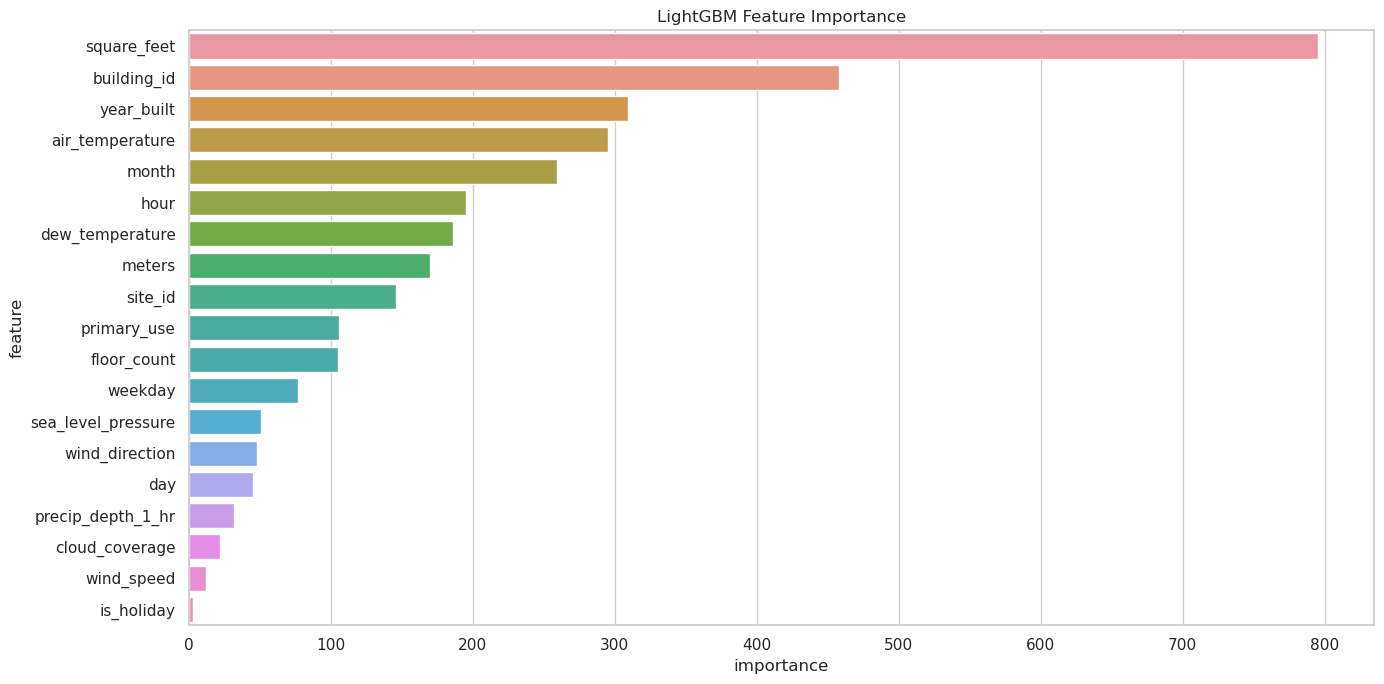

In [89]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = train_lgb.feature_name
df_fimp["importance"] = lgb_model.feature_importance()

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

**With this scaling**, we can see that **our model is able to provide non constant outputs**

In [90]:
y_pred = lgb_model.predict(X_test)
y_pred = y_pred.reshape(len(y_pred),1)
y_pred = np.expm1(y_pred)
row_ids = X_test.reset_index()['index'].values

In [91]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(np.clip(y_pred, 0, a_max=None).reshape(len(y_pred)), 0, a_max=None)})
submission.to_csv("submission.csv", index=False)

In [92]:
os.remove("/kaggle/working/train_full_w_outliers.csv") 
os.remove("/kaggle/working/test_full.csv") 
os.remove("/kaggle/working/train_full_wo_outliers.csv") 

Score on Kaggle: **1.547**

## RNN methods

We will test another method: **RNNs**. 

In order to use this kind of model, we need to transform our data to create inputs with correct shapes.

The **shape for our training set** will be as followed: **(# building<>Meter, defined timestamp, features).**

In [93]:
## Download all the different data
#train_raw = pd.read_csv("train.csv", sep = ',')
#test_raw = pd.read_csv("test.csv", sep = ',')
#b_meta = pd.read_csv("building_metadata.csv",sep = ',')
#w_train = pd.read_csv("weather_train.csv",sep = ',')
#w_test = pd.read_csv("weather_test.csv",sep = ',')
#sample = pd.read_csv("sample_submission.csv",sep = ',')

In [94]:
## We reduce memory usage to preserve RAM
#train_raw = reduce_mem_usage(train_raw, use_float16=True)
#test_raw = reduce_mem_usage(test_raw, use_float16=True)
#b_meta = reduce_mem_usage(b_meta, use_float16=True)
#w_train = reduce_mem_usage(w_train, use_float16=True)
#w_test = reduce_mem_usage(w_test, use_float16=True)
#sample = reduce_mem_usage(sample, use_float16=True)

**Prepare Building Metadata**

In [95]:
#year_built_gp = b_meta.groupby('site_id')['year_built']

In [96]:
## Fill in missing year_built with the mean of other buildings in the same site; 
## if none of the buildings in a site has year_built, then fill with the mean of the entire dataset
#year_built_gp = b_meta.groupby('site_id')['year_built']
#b_meta['year_built'] = year_built_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
#b_meta['year_built'].fillna(np.floor(np.nanmean(b_meta['year_built'].astype(float))), inplace=True)
#assert pd.isnull(b_meta['year_built']).sum() == 0


## Fill in missing floor_count with the mean of other buildings of the same primary_use; 
## if none of the buildings of a primary use has year_built, then fill with the mean of the entire dataset
#floor_count_gp = b_meta.groupby('primary_use')['floor_count']
#b_meta['floor_count'] = floor_count_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
#b_meta['floor_count'].fillna(np.floor(np.nanmean(b_meta['floor_count'].astype(float))), inplace=True)
#assert pd.isnull(b_meta['floor_count']).sum() == 0

## To conserve RAM:
#del year_built_gp, floor_count_gp

#gc.collect()

**Weather data**

In [97]:
## The following function is inspired by https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
#def add_missing_hours(weather_df):
#    import datetime
#    time_format = "%Y-%m-%d %H:%M:%S"
#    start_date = datetime.datetime.strptime(weather_df['timestamp'].cat.as_ordered().min(),time_format)
#    end_date = datetime.datetime.strptime(weather_df['timestamp'].cat.as_ordered().max(),time_format)
#    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
#    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

#    for site_id in range(16):
#        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
#        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
#        new_rows['site_id'] = site_id
#        weather_df = pd.concat([weather_df,new_rows]).reset_index(drop=True)
#    return weather_df

#w_train = add_missing_hours(w_train)
#w_test = add_missing_hours(w_test)

In [98]:
#weath_col = ['air_temperature', 'cloud_coverage',
#       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
#       'wind_direction', 'wind_speed']

## Train set
## Interpolate the missing data
#for i in range(w_train['site_id'].nunique()):
#    w_train[w_train['site_id']==i] = w_train[w_train['site_id']==i].sort_values(by='timestamp').interpolate(method='linear', limit_direction='forward', axis=0)

## for the remaining missing values, we impute with the mean values of the site id x month
#w_train['timestamp'] = pd.to_datetime(w_train['timestamp'])
#w_train['month'] = w_train['timestamp'].dt.month
#gp = w_train.groupby(['site_id', 'month'])
#for col in weath_col:
#    w_train[col] = gp[col].transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
#    w_train[col].fillna(np.nanmean(w_train[col].astype(float)), inplace=True)

    
## We do the same with the test set
#for i in range(w_test['site_id'].nunique()):
#    w_test[w_test['site_id']==i] = w_test[w_test['site_id']==i].sort_values(by='timestamp').interpolate(method='linear', limit_direction='forward', axis=0)

#w_test['timestamp'] = pd.to_datetime(w_test['timestamp'])
#w_test['month'] = w_test['timestamp'].dt.month
#gp = w_test.groupby(['site_id', 'month'])
#for col in weath_col:
#    w_test[col] = gp[col].transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
#    w_test[col].fillna(np.nanmean(w_test[col].astype(float)), inplace=True)

**Preparing all data**

In [99]:
## Combination if all dates possible in train and test sets
#all_dates_train = pd.DataFrame(np.sort(train_raw['timestamp'].unique()),columns=['timestamp'])
#all_dates_test = pd.DataFrame(np.sort(test_raw['timestamp'].unique()),columns=['timestamp'])

In [100]:
## Combination if all building possible in train and test sets
#all_building_train = pd.DataFrame(train_raw['building_id'].unique(),columns=['building_id'])
#all_building_test = pd.DataFrame(test_raw['building_id'].unique(),columns=['building_id'])

In [101]:
## Combination if all building and meter combinations in train and test sets
#all_building_meter_train = train_raw.groupby(['building_id','meter']).size().reset_index().drop(0,axis=1)
#all_building_meter_test = test_raw.groupby(['building_id','meter']).size().reset_index().drop(0,axis=1)

In [102]:
## Preparing keys to proceed a cross join
#all_dates_train['key'] = 0
#all_building_train['key'] = 0
#all_dates_test['key'] = 0
#all_building_test['key'] = 0
#all_building_meter_train['key'] = 0
#all_building_meter_test['key'] = 0

In [103]:
## Join meter, building ids and dates altogether
#building_time_train = all_building_meter_train.merge(all_dates_train, on='key', how='outer').drop('key',axis=1)
#building_time_test = all_building_meter_train.merge(all_dates_test, on='key', how='outer').drop('key',axis=1)

In [104]:
## Joining building metadata
#building_full_train = building_time_train.merge(b_meta, on='building_id')
#building_full_test = building_time_test.merge(b_meta, on='building_id')

In [105]:
## Joining data with train and test data
#train_full = building_full_train.merge(train_raw,on=['building_id','timestamp','meter'], how='left')
#test_full = building_full_test.merge(test_raw,on=['building_id','timestamp','meter'], how='left')

In [106]:
## Converting to datetime
#train_full['timestamp'] = pd.to_datetime(train_full['timestamp'])
#test_full['timestamp'] = pd.to_datetime(test_full['timestamp'])
## Joining weather data
#train_full = train_full.merge(w_train, on=['site_id','timestamp'], how='left')
#test_full = test_full.merge(w_test, on=['site_id','timestamp'], how='left')

In [107]:
## clearing memory
#del all_dates_train, all_building_train, all_dates_test, all_building_test
#gc.collect()
#all_building_meter_train.drop('key',axis=1, inplace=True)
#all_building_meter_test.drop('key',axis=1, inplace=True)

In [108]:
## Some variables to variate feature engineering
#test = "ok" # Apply feature engineering to test set

## Some variables for features engineering
#holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
#            "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
#            "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
#            "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
#            "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
#            "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
#            "2019-01-01"]

#features_label = ['building_id', 'site_id', 'primary_use',
#       'square_feet', 'year_built', 'floor_count', 'air_temperature',
#       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
#       'sea_level_pressure', 'wind_direction', 'wind_speed', 'meter', 'month', 'weekday',
#       'hour', 'day', 'is_holiday']

#numerical_features = ['square_feet',
#       'year_built', 'floor_count', 'air_temperature',
#       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
#       'wind_direction', 'wind_speed']

#categorical_features = ["building_id", "site_id", "meters", "primary_use", "hour", "weekday", "month", "cloud_coverage", "is_holiday"]

#train_full['timestamp'] = pd.to_datetime(train_full['timestamp'])
#test_full['timestamp'] = pd.to_datetime(test_full['timestamp'])

## Label Encode Primary Use
#le = LabelEncoder()
#train_full['primary_use'] = le.fit_transform(train_full['primary_use'])

#if test is not None:
#    test_full['primary_use'] = le.transform(test_full['primary_use'])


## Extract information from timestamp
#train_full['month'] = train_full['timestamp'].dt.month
#train_full['weekday'] = train_full['timestamp'].dt.weekday
#train_full['hour'] = train_full['timestamp'].dt.hour
#train_full['day'] = train_full['timestamp'].dt.day

#if test is not None:
#    test_full['month'] = test_full['timestamp'].dt.month
#    test_full['weekday'] = test_full['timestamp'].dt.weekday
#    test_full['hour'] = test_full['timestamp'].dt.hour
#    test_full['day'] = test_full['timestamp'].dt.day

    
## Add holidays feature
#train_full["is_holiday"] = (train_full['timestamp'].dt.date.astype("str").isin(holidays)).astype(int)

#if test is not None:
#    test_full["is_holiday"] = (test_full['timestamp'].dt.date.astype("str").isin(holidays)).astype(int) 
    

## Split train data for the scaling (in particular for minmaxscale)

#train_full['square_feet'] = np.log1p(train_full['square_feet'])
#train_full['meter_reading'] = np.log1p(train_full['meter_reading'])
#if test is not None:
#    test_full['square_feet'] = np.log1p(test_full['square_feet'])

**Padding the data**

After filling all the missing values, we will now prepare the data in order to have the wanted shape.

As all the building x meter does not have the same length historic, we will keep all the data having at least 8000 records in the train set.

In [109]:
#threshold = 8000
#train_pad = []
#target_pad = []
#for i, j in all_building_meter_train.values:
#    # We want at least 8000 metric reading entries
#    if train_full[(train_full['building_id']==i)&(train_full['meter']==j)].isna().sum()['meter_reading']<(8784-threshold): 
#        train_pad.append(np.float32(train_full[(train_full['building_id']==i)&(train_full['meter']==j)][features_label].dropna()[-8000:]))
#        target_pad.append(train_full[(train_full['building_id']==i)&(train_full['meter']==j)]['meter_reading'].dropna()[-8000:])


In [110]:
## Stack the data to get final train set
#train_final = np.stack(train_pad)
#target_final = np.array(target_pad)

In [111]:
#print(train_final.shape, target_final.shape)

**Model Creation**

In [112]:
#train_ds = tf.data.Dataset.from_tensor_slices((train_final, target_final))

In [113]:
## Create a simple RNN model
#num_features = len(features_label)

#model = tf.keras.Sequential()

## Add RNN: LSTM layer
#model.add(tf.keras.layers.LSTM(units=32,
#                               input_shape = (None, num_features),
#                               dropout = 0.2, 
#                               return_sequences = True)) 

## Add output layer
#model.add(tf.keras.layers.Dense(1)) 


In [114]:
## Compile model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
#              loss='mse',
#              metrics=[tf.keras.metrics.RootMeanSquaredError()])#, 
#                       #tf.keras.metrics.MeanSquaredLogarithmicError()])
#model.summary()

**Model Training**

In [115]:
## Train our RNN model
#model.fit(train_ds.shuffle(50).batch(10), 
#          epochs=30, 
#          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

In [116]:
## Save our RNN model
#model.save('rnn_model')

In [117]:
## Load model if necessary
#model = tf.keras.models.load_model('rnn_model')

**Make Prediction**

In [118]:
#test_full['meter_reading'] = np.zeros(test_full.shape[0], dtype=np.float32)

In [119]:
## make prediction on the test set
#for i, j in all_building_meter_test.values:
#    ts = np.expand_dims(test_full[(test_full['building_id']==i)&(test_full['meter']==j)][features_label].values, axis=0) 
#    res = np.float32(np.expm1(model.predict(ts).squeeze()))
#    del ts
#    test_full.loc[(test_full['building_id']==i)&(test_full['meter']==j), 'meter_reading'] = res
#    del res
#gc.collect()

In [120]:
#sample_sub = pd.read_csv('sample_submission.csv',
#                         usecols=['row_id'])

In [121]:
#sample_sub = sample_sub.merge(test_full[['row_id', 'meter_reading']], on='row_id')

In [122]:
# save for submissions on Kaggle
#sample_sub.to_csv('submission_14_02_2023.csv', index=False)

Results on Kaggle: **1.653**

# Conclusion & Further Improvements

**CONCLUSION**

<ins> EDA <ins>
- In this Kernel, we have done first a deep EDA enabling us to understand what is our train and test set and what are their caracteristics. 

<ins>Feature Engineering<ins>
- After that, we have tried several technics with the data engineering with a various combination between label encoding vs min-max scaling vs standard scaling vs log scaling, label encoding vs one-hot encoding. We have chosen the most promising ones using a simple LightGBM model and a sample of our train set. 


<ins> LightGBM Optimization <ins>
- Using these best feature engineerings, we have optimized our LightGBM model using Optuna during its training. We have been able to see the improvements that we have had using Optuna.

<ins> RNN Model <ins>
- Finally, we have tried another approach with a RNN model. To do so, we have used a simple one layer LSTM model. Some specific feature engineerings have been done: 1) make train and test sets' shape adapted for our model and 2) make some imputations on missing data, scale data or encode features.

**POSSIBLE IMPROVEMENTS**

Some improvements can be done in this Kernel. 

- For the EDA part: when possible display meter_reading to vizualize potential correlation with the feature
- For the feature engineering part: 1) See the correlation between the different features, 2) Do a better imputation for the missing values
- For the modelling part, 1) make a better cross validation using for example  a blocked cross validation instead of a half and half validation, 3) improve the RNN model using a more complex one and try some more regularization.
